In [1]:
from kuramoto.nmf import *
from kuramoto.SDL_BCD import SDL_BCD

In [2]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 1600
X.shape (2500, 1600)


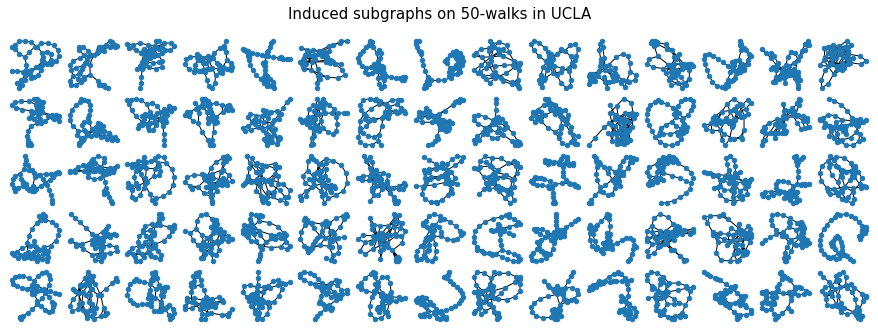

In [3]:
X, embs = G.get_patches(k=k, sample_size=1600, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 1600


In [5]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 1

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

0    1    2    3    4    5    6    7    8    9  ...  2491  2492  2493  \
0     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1     0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
1595  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1596  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1597  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1598  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1599  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

      2494  2495  2496  2497  2498  2499  Synchronized  
0      0.0   0.0   0.0   0.0   1.0   0.0          True  
1      0.0   0.0   1.0   1.0   1.0   0.0         False  
2      0.0   0.0   0.0   0.0   1.0   0.0         False  
3      0.0   0.0   1.0   1.0   1.0   0.0         False  
4      0.0   0.0   0.0   0.0   1.0   0.0         False  
...    ...   ...   ...   ...   ...   ...           ...  
1595   0.0   0.0   0.0   0.0   1.0   0.0         False  
1596   0.0   0.0   0.0   0.0   1.0   0.0         False  
1597   0.0   0.0   0.0   0.0   1.0   0.0         False  
1598   0.0   0.0   0.0   0.0   1.0   0.0          True  
1599   0.0   0.0   0.0   0.0   1.0   0.0         False  

[1600 rows x 2501 columns]

In [6]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.273125


In [7]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [8]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  5%|█▉                                       | 12/250 [00:00<00:02, 108.41it/s]

iteration 0, reconstruction error 72377.789525
iteration 10, reconstruction error 30275.699968


 14%|█████▋                                   | 35/250 [00:00<00:02, 102.35it/s]

iteration 20, reconstruction error 31492.755073
iteration 30, reconstruction error 32337.131561
iteration 40, reconstruction error 32297.889510


 27%|███████████▏                             | 68/250 [00:00<00:01, 101.81it/s]

iteration 50, reconstruction error 31851.020946
iteration 60, reconstruction error 30709.442885


 36%|██████████████▉                          | 91/250 [00:00<00:01, 106.09it/s]

iteration 70, reconstruction error 28807.695312
iteration 80, reconstruction error 27064.632987
iteration 90, reconstruction error 26491.678455


 45%|██████████████████                      | 113/250 [00:01<00:01, 102.44it/s]

iteration 100, reconstruction error 26259.010290
iteration 110, reconstruction error 26107.300701


 54%|█████████████████████▉                   | 134/250 [00:01<00:01, 91.87it/s]

iteration 120, reconstruction error 26002.369707
iteration 130, reconstruction error 25924.780939


 62%|█████████████████████████▎               | 154/250 [00:01<00:01, 87.72it/s]

iteration 140, reconstruction error 25865.676528
iteration 150, reconstruction error 25820.127587


 70%|████████████████████████████▌            | 174/250 [00:01<00:00, 88.09it/s]

iteration 160, reconstruction error 25784.623662
iteration 170, reconstruction error 25756.555278


 77%|███████████████████████████████▋         | 193/250 [00:02<00:00, 91.14it/s]

iteration 180, reconstruction error 25733.708436
iteration 190, reconstruction error 25715.042874


 86%|███████████████████████████████████▎     | 215/250 [00:02<00:00, 97.07it/s]

iteration 200, reconstruction error 25699.377508
iteration 210, reconstruction error 25686.087184
iteration 220, reconstruction error 25674.662073


100%|█████████████████████████████████████████| 250/250 [00:02<00:00, 95.84it/s]


iteration 230, reconstruction error 25664.606621
iteration 240, reconstruction error 25655.660703


###########################
Shape of W_true: (2500, 9)
###########################




  2%|▊                                          | 5/250 [00:00<00:05, 42.02it/s]

iteration 0, reconstruction error 182255.478837


  6%|██▋                                       | 16/250 [00:00<00:04, 47.22it/s]

iteration 10, reconstruction error 70667.529335


 10%|████▎                                     | 26/250 [00:00<00:06, 35.40it/s]

iteration 20, reconstruction error 74329.344307


 15%|██████▏                                   | 37/250 [00:00<00:05, 42.37it/s]

iteration 30, reconstruction error 76985.480748


 19%|███████▉                                  | 47/250 [00:01<00:04, 42.52it/s]

iteration 40, reconstruction error 77118.967464


 23%|█████████▌                                | 57/250 [00:01<00:04, 42.67it/s]

iteration 50, reconstruction error 77042.613580


 25%|██████████▍                               | 62/250 [00:01<00:05, 36.25it/s]

iteration 60, reconstruction error 76829.897900


 30%|████████████▊                             | 76/250 [00:01<00:04, 37.60it/s]

iteration 70, reconstruction error 76319.540300


 34%|██████████████▎                           | 85/250 [00:02<00:04, 36.61it/s]

iteration 80, reconstruction error 75160.826520


 40%|████████████████▍                        | 100/250 [00:02<00:03, 41.62it/s]

iteration 90, reconstruction error 72742.944909


 42%|█████████████████▏                       | 105/250 [00:02<00:03, 40.79it/s]

iteration 100, reconstruction error 68483.671931


 46%|██████████████████▊                      | 115/250 [00:03<00:03, 35.76it/s]

iteration 110, reconstruction error 63822.643580


 51%|████████████████████▉                    | 128/250 [00:03<00:03, 38.05it/s]

iteration 120, reconstruction error 62068.660423


 55%|██████████████████████▍                  | 137/250 [00:03<00:02, 39.40it/s]

iteration 130, reconstruction error 61596.794265


 59%|████████████████████████                 | 147/250 [00:03<00:02, 40.38it/s]

iteration 140, reconstruction error 61268.636598


 61%|████████████████████████▉                | 152/250 [00:03<00:02, 37.64it/s]

iteration 150, reconstruction error 61025.282568


 66%|██████████████████████████▉              | 164/250 [00:04<00:02, 29.87it/s]

iteration 160, reconstruction error 60845.869202


 72%|█████████████████████████████▌           | 180/250 [00:04<00:01, 39.93it/s]

iteration 170, reconstruction error 60713.572042


 74%|██████████████████████████████▎          | 185/250 [00:04<00:01, 38.17it/s]

iteration 180, reconstruction error 60615.077440


 78%|███████████████████████████████▉         | 195/250 [00:05<00:01, 40.65it/s]

iteration 190, reconstruction error 60540.183048


 83%|█████████████████████████████████▉       | 207/250 [00:05<00:00, 45.54it/s]

iteration 200, reconstruction error 60481.518170
iteration 210, reconstruction error 60434.515327


 92%|█████████████████████████████████████▌   | 229/250 [00:05<00:00, 48.58it/s]

iteration 220, reconstruction error 60396.025783


 96%|███████████████████████████████████████▎ | 240/250 [00:06<00:00, 47.27it/s]

iteration 230, reconstruction error 60363.821233


100%|█████████████████████████████████████████| 250/250 [00:06<00:00, 39.71it/s]

iteration 240, reconstruction error 60336.555441


###########################
Shape of W_false: (2500, 9)
###########################




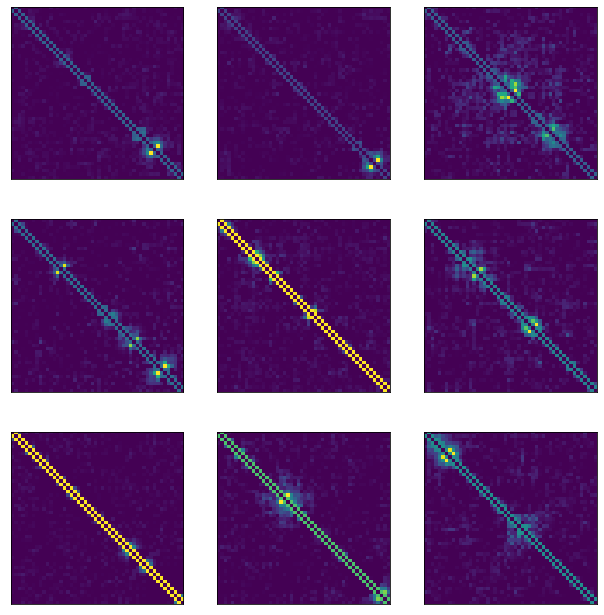

In [9]:
display_dictionary(W = W_true,
                   figsize = [10,10])

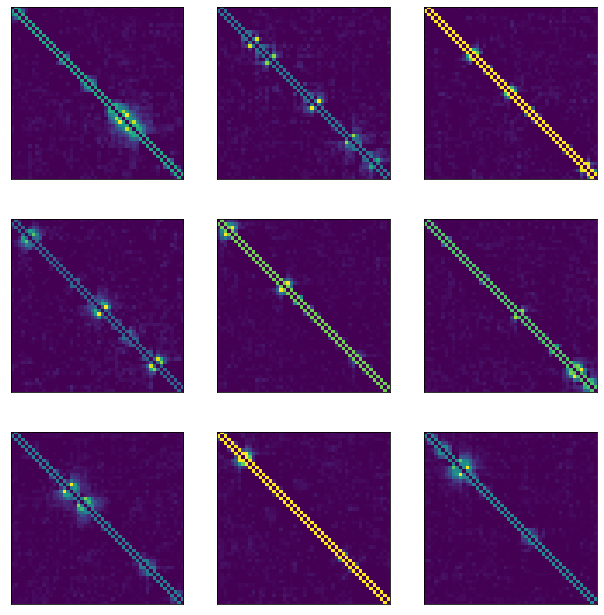

In [10]:
display_dictionary(W = W_false,
                   figsize = [10,10])

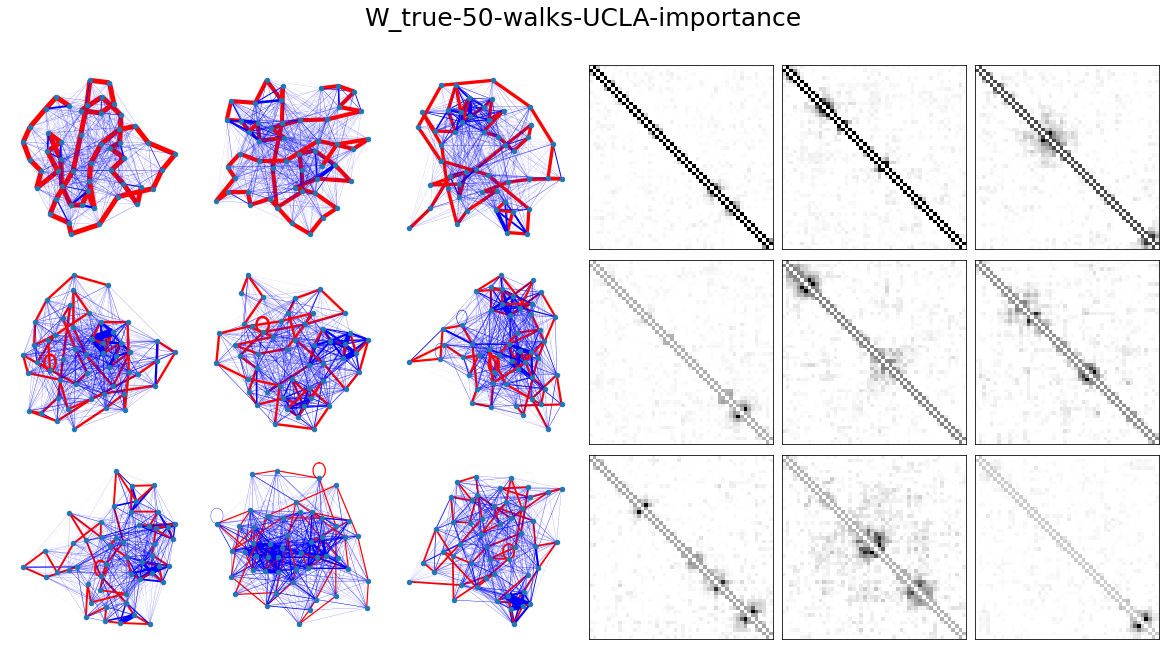

In [11]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

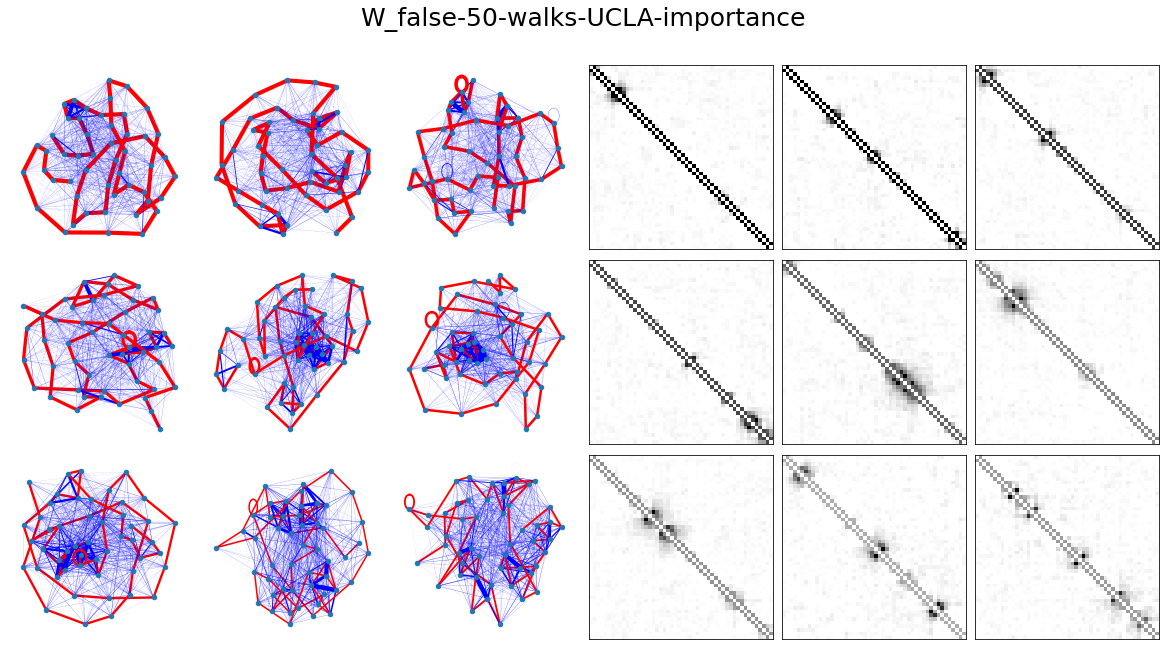

In [12]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

In [13]:
true_norm = np.linalg.norm(W_true.T, ord=1, axis=1)
false_norm = np.linalg.norm(W_false.T, ord=1, axis=1)

In [14]:
data_arr = np.stack((true_norm, false_norm), axis=0).T
df_boxplot = pd.DataFrame(data_arr, columns = ['Synchronizing','Non-Synchronizing'])
df_boxplot

Synchronizing  Non-Synchronizing
0       4.967271           5.148659
1       4.223170           4.305167
2       5.283560           5.391169
3       4.536028           4.078985
4       5.965815           5.015332
5       5.296790           4.963390
6       6.267693           4.999314
7       5.586421           5.383777
8       5.362622           4.724525

In [15]:
# sns.set(rc={'figure.figsize':(6, 4)})
# sns.set(font_scale = 1)

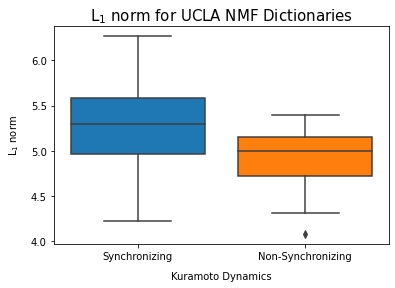

In [16]:
ax = sns.boxplot(data=df_boxplot, saturation=1)
ax.axes.set_title("L$_1$ norm for UCLA NMF Dictionaries", fontsize=15)
plt.xlabel("Kuramoto Dynamics", labelpad=10)
plt.ylabel("L$_1$ norm", labelpad=10);

In [13]:
X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = 0.25,
                                                    stratify = Y)

In [14]:
# SDL_BCD_feature
data_scale=10
results_dict_list = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                X_test = [X_test.T/data_scale, Y_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new = SDL_BCD_class.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.89627514 -0.29795767 -0.083142   -0.13594359 -0.94728733  0.63240812
  -0.37061383  0.33181381  0.29252418 -0.89800465 -0.09721896  0.01392278
   0.3509387   0.49990838  0.19085687 -0.17632714 -0.33386548]]


  0%|▏                                          | 1/200 [00:00<00:35,  5.54it/s]

--- Training --- [threshold, AUC] =  [0.53, 0.589]
--- Iteration 0: Training loss --- [Data, Label, Total] = [675.083371.3, 1305.473247.3, 1305.473247.3]


  5%|██                                        | 10/200 [00:00<00:16, 11.30it/s]

--- Training --- [threshold, AUC] =  [0.98, 0.528]
--- Iteration 10: Training loss --- [Data, Label, Total] = [909.718180.3, 3747.085350.3, 3747.085350.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[-0.38195758  0.17780019 -0.19683959 -0.89511071 -0.84195053  0.13429342
  -0.98940056  0.5536048  -0.79900039  0.75079933 -0.1609831  -0.40837046
   0.17537263 -0.23021443 -0.20790072  0.29665478 -0.06647491]]


  2%|▊                                          | 4/200 [00:00<00:16, 12.11it/s]

--- Training --- [threshold, AUC] =  [1.679, 0.397]
--- Iteration 0: Training loss --- [Data, Label, Total] = [685.115561.3, 1443.381443.3, 1443.381443.3]


  5%|██                                        | 10/200 [00:01<00:19,  9.73it/s]


--- Training --- [threshold, AUC] =  [1.0, 0.419]
--- Iteration 10: Training loss --- [Data, Label, Total] = [942.608236.3, 12932.172035.3, 12932.172035.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.40992966  0.01680211 -0.87797165 -0.90150918  0.71947747 -0.79855329
  -0.7963283  -0.11019299 -0.06191938 -0.35194251  0.42106    -0.43389797
   0.48334362  0.86089163 -0.74586996  0.32346265 -0.6477067 ]]


  0%|▏                                          | 1/200 [00:00<00:28,  7.10it/s]

--- Training --- [threshold, AUC] =  [0.436, 0.605]
--- Iteration 0: Training loss --- [Data, Label, Total] = [686.417977.3, 1310.246111.3, 1378.887909.3]


  5%|██                                        | 10/200 [00:00<00:15, 12.33it/s]


--- Training --- [threshold, AUC] =  [0.023, 0.636]
--- Iteration 10: Training loss --- [Data, Label, Total] = [878.247549.3, 3492.677015.3, 3580.501770.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.51672407 -0.95770257  0.34964179  0.87920016  0.38369346 -0.71934713
  -0.29108565 -0.16453353  0.40465495  0.98713301 -0.32770359  0.25869771
   0.02558683  0.86555449  0.51018853  0.13459184  0.26555866]]


  0%|▏                                          | 1/200 [00:00<00:24,  8.20it/s]

--- Training --- [threshold, AUC] =  [0.616, 0.398]
--- Iteration 0: Training loss --- [Data, Label, Total] = [699.113621.3, 1361.202875.3, 1431.114238.3]


  5%|██                                        | 10/200 [00:00<00:11, 16.95it/s]


--- Training --- [threshold, AUC] =  [1.0, 0.467]
--- Iteration 10: Training loss --- [Data, Label, Total] = [864.654225.3, 12046.700433.3, 12133.165855.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.81214098 -0.54495366 -0.90080617 -0.58841278 -0.29817558 -0.08281641
  -0.21489877  0.17473896  0.78549539 -0.28488876  0.10351661  0.52143418
   0.16950247 -0.18605311 -0.09351472 -0.43414313 -0.51183031]]


  0%|▏                                          | 1/200 [00:00<00:23,  8.56it/s]

--- Training --- [threshold, AUC] =  [1.448, 0.396]
--- Iteration 0: Training loss --- [Data, Label, Total] = [647.780280.3, 1305.831302.3, 1953.611582.3]


  5%|██                                        | 10/200 [00:00<00:14, 13.48it/s]


--- Training --- [threshold, AUC] =  [0.131, 0.652]
--- Iteration 10: Training loss --- [Data, Label, Total] = [533.113017.3, 2000.426686.3, 2533.539703.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.8510875  -0.84087238 -0.09628237  0.19954157  0.92950287 -0.95613673
   0.60982746  0.53278482 -0.87179003  0.97269888 -0.66738948 -0.79008661
  -0.44947121  0.69663227  0.20102858  0.16948563 -0.50972834]]


  3%|█▎                                         | 6/200 [00:00<00:07, 25.92it/s]

--- Training --- [threshold, AUC] =  [1.502, 0.395]
--- Iteration 0: Training loss --- [Data, Label, Total] = [676.811876.3, 1299.779342.3, 1976.591218.3]


  5%|██                                        | 10/200 [00:00<00:10, 18.79it/s]


--- Training --- [threshold, AUC] =  [0.913, 0.444]
--- Iteration 10: Training loss --- [Data, Label, Total] = [535.398644.3, 2418.081107.3, 2953.479751.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.57625668 -0.29152351 -0.30943674 -0.72017134  0.02110054 -0.52308372
  -0.73408372 -0.44485576  0.05324399  0.7843667   0.18862291  0.71763144
   0.22144437  0.82576522  0.13602187 -0.91056379 -0.97729378]]


  0%|▏                                          | 1/200 [00:00<00:20,  9.50it/s]

--- Training --- [threshold, AUC] =  [0.439, 0.604]
--- Iteration 0: Training loss --- [Data, Label, Total] = [569.483995.3, 1309.073969.3, 4156.493942.3]


  5%|██                                        | 10/200 [00:00<00:10, 17.97it/s]

--- Training --- [threshold, AUC] =  [0.884, 0.617]
--- Iteration 10: Training loss --- [Data, Label, Total] = [272.428589.3, 2172.150457.3, 3534.293402.3]


 11%|████▌                                     | 22/200 [00:01<00:12, 14.28it/s]

--- Training --- [threshold, AUC] =  [0.901, 0.49]
--- Iteration 20: Training loss --- [Data, Label, Total] = [130.950728.3, 2310.188394.3, 2964.942035.3]


 17%|███████▏                                  | 34/200 [00:02<00:10, 15.63it/s]

--- Training --- [threshold, AUC] =  [0.797, 0.435]
--- Iteration 30: Training loss --- [Data, Label, Total] = [127.070033.3, 1735.575166.3, 2370.925330.3]


 22%|█████████▏                                | 44/200 [00:02<00:09, 15.63it/s]

--- Training --- [threshold, AUC] =  [0.716, 0.442]
--- Iteration 40: Training loss --- [Data, Label, Total] = [4.842519.3, 1510.919679.3, 1535.132273.3]


 26%|███████████▏                              | 53/200 [00:03<00:09, 15.68it/s]

--- Training --- [threshold, AUC] =  [0.705, 0.705]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.607726.3, 1488.413257.3, 1491.451888.3]


 32%|█████████████▍                            | 64/200 [00:04<00:08, 16.20it/s]

--- Training --- [threshold, AUC] =  [0.7, 0.721]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.452347.3, 1479.983253.3, 1482.244987.3]


 36%|███████████████                           | 72/200 [00:04<00:09, 13.60it/s]

--- Training --- [threshold, AUC] =  [0.696, 0.72]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.443555.3, 1472.123621.3, 1474.341398.3]


 42%|█████████████████▊                        | 85/200 [00:05<00:05, 19.88it/s]

--- Training --- [threshold, AUC] =  [0.693, 0.718]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.442107.3, 1467.396305.3, 1469.606842.3]


 46%|███████████████████▌                      | 93/200 [00:05<00:06, 16.55it/s]

--- Training --- [threshold, AUC] =  [0.691, 0.716]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.440503.3, 1463.568749.3, 1465.771267.3]


 52%|█████████████████████▌                   | 105/200 [00:06<00:05, 16.89it/s]

--- Training --- [threshold, AUC] =  [0.689, 0.714]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.438487.3, 1459.899020.3, 1462.091456.3]


 57%|███████████████████████▌                 | 115/200 [00:07<00:04, 20.94it/s]

--- Training --- [threshold, AUC] =  [0.687, 0.712]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.436115.3, 1456.224119.3, 1458.404692.3]


 60%|████████████████████████▊                | 121/200 [00:07<00:04, 18.96it/s]

--- Training --- [threshold, AUC] =  [0.686, 0.711]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.433590.3, 1453.856631.3, 1456.024583.3]


 67%|███████████████████████████▍             | 134/200 [00:08<00:03, 19.05it/s]

--- Training --- [threshold, AUC] =  [0.685, 0.71]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.431153.3, 1452.665281.3, 1454.821045.3]


 72%|█████████████████████████████▌           | 144/200 [00:08<00:02, 22.38it/s]

--- Training --- [threshold, AUC] =  [0.683, 0.71]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.429155.3, 1449.519549.3, 1451.665325.3]


 76%|███████████████████████████████▎         | 153/200 [00:09<00:02, 18.53it/s]

--- Training --- [threshold, AUC] =  [0.681, 0.71]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.427744.3, 1446.626117.3, 1448.764837.3]


 82%|█████████████████████████████████▊       | 165/200 [00:09<00:01, 22.16it/s]

--- Training --- [threshold, AUC] =  [0.68, 0.712]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.426863.3, 1444.174223.3, 1446.308539.3]


 87%|███████████████████████████████████▋     | 174/200 [00:10<00:01, 21.54it/s]

--- Training --- [threshold, AUC] =  [0.678, 0.714]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.426349.3, 1441.033331.3, 1443.165077.3]


 93%|██████████████████████████████████████▏  | 186/200 [00:10<00:00, 21.65it/s]

--- Training --- [threshold, AUC] =  [0.676, 0.715]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.426055.3, 1438.749100.3, 1440.879376.3]


 98%|████████████████████████████████████████▏| 196/200 [00:11<00:00, 24.97it/s]

--- Training --- [threshold, AUC] =  [0.675, 0.716]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.425877.3, 1436.058760.3, 1438.188145.3]


100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 17.90it/s]


!!! pred_type naive
initial loading beta [[-0.83684736  0.78069916  0.414815    0.73646    -0.86589984 -0.70025771
   0.61947526  0.39657957 -0.51698581 -0.70573117  0.11853871  0.97249612
   0.28310798 -0.21533084 -0.27463924 -0.12117478 -0.29934825]]


  2%|▊                                          | 4/200 [00:00<00:09, 19.74it/s]

--- Training --- [threshold, AUC] =  [0.574, 0.604]
--- Iteration 0: Training loss --- [Data, Label, Total] = [558.542178.3, 1326.021934.3, 4118.732826.3]


  5%|██                                        | 10/200 [00:00<00:10, 18.87it/s]


--- Training --- [threshold, AUC] =  [0.991, 0.658]
--- Iteration 10: Training loss --- [Data, Label, Total] = [248.733270.3, 4559.718952.3, 5803.385301.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.77361983  0.39816004  0.79511222  0.42268643  0.14266853  0.31239694
   0.74940088  0.75514535 -0.35194635 -0.16089853 -0.81264456  0.67355823
  -0.46647146  0.9896141  -0.2531401   0.69888696 -0.06460482]]


  2%|▊                                          | 4/200 [00:00<00:09, 21.06it/s]

--- Training --- [threshold, AUC] =  [0.484, 0.604]
--- Iteration 0: Training loss --- [Data, Label, Total] = [570.824410.3, 1299.374431.3, 7007.618527.3]


  6%|██▋                                       | 13/200 [00:00<00:10, 18.26it/s]

--- Training --- [threshold, AUC] =  [0.129, 0.624]
--- Iteration 10: Training loss --- [Data, Label, Total] = [244.978001.3, 2013.812697.3, 4463.592710.3]


 12%|█████▎                                    | 25/200 [00:01<00:08, 20.07it/s]

--- Training --- [threshold, AUC] =  [0.39, 0.654]
--- Iteration 20: Training loss --- [Data, Label, Total] = [156.328743.3, 1337.679066.3, 2900.966497.3]


 17%|███████▏                                  | 34/200 [00:01<00:09, 17.90it/s]

--- Training --- [threshold, AUC] =  [0.476, 0.649]
--- Iteration 30: Training loss --- [Data, Label, Total] = [65.561635.3, 1299.913648.3, 1955.529998.3]


 23%|█████████▋                                | 46/200 [00:02<00:07, 21.17it/s]

--- Training --- [threshold, AUC] =  [0.514, 0.714]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.004203.3, 1301.536215.3, 1311.578242.3]


 27%|███████████▎                              | 54/200 [00:02<00:07, 18.90it/s]

--- Training --- [threshold, AUC] =  [0.497, 0.717]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.454638.3, 1299.470032.3, 1304.016413.3]


 32%|█████████████▍                            | 64/200 [00:03<00:07, 17.45it/s]

--- Training --- [threshold, AUC] =  [0.494, 0.718]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.441644.3, 1299.301555.3, 1303.717998.3]


 38%|███████████████▉                          | 76/200 [00:03<00:05, 22.34it/s]

--- Training --- [threshold, AUC] =  [0.493, 0.72]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.436550.3, 1299.292991.3, 1303.658488.3]


 43%|██████████████████                        | 86/200 [00:04<00:04, 23.35it/s]

--- Training --- [threshold, AUC] =  [0.492, 0.721]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.431961.3, 1299.273081.3, 1303.592696.3]


 46%|███████████████████▎                      | 92/200 [00:04<00:05, 20.20it/s]

--- Training --- [threshold, AUC] =  [0.492, 0.722]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.428700.3, 1299.267188.3, 1303.554183.3]


 52%|█████████████████████▎                   | 104/200 [00:05<00:04, 22.31it/s]

--- Training --- [threshold, AUC] =  [0.492, 0.723]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.426900.3, 1299.272398.3, 1303.541399.3]


 58%|███████████████████████▊                 | 116/200 [00:05<00:03, 23.05it/s]

--- Training --- [threshold, AUC] =  [0.491, 0.724]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.426054.3, 1299.252264.3, 1303.512808.3]


 62%|█████████████████████████▋               | 125/200 [00:06<00:03, 21.94it/s]

--- Training --- [threshold, AUC] =  [0.489, 0.726]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.425665.3, 1299.244862.3, 1303.501517.3]


 67%|███████████████████████████▍             | 134/200 [00:06<00:03, 21.33it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.726]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.425471.3, 1299.243921.3, 1303.498633.3]


 73%|█████████████████████████████▉           | 146/200 [00:07<00:02, 23.21it/s]

--- Training --- [threshold, AUC] =  [0.489, 0.726]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.425366.3, 1299.245856.3, 1303.499515.3]


 78%|███████████████████████████████▊         | 155/200 [00:07<00:02, 21.39it/s]

--- Training --- [threshold, AUC] =  [0.489, 0.727]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.425306.3, 1299.246765.3, 1303.499828.3]


 82%|█████████████████████████████████▊       | 165/200 [00:07<00:01, 25.51it/s]

--- Training --- [threshold, AUC] =  [0.487, 0.727]
--- Iteration 160: Training loss --- [Data, Label, Total] = [nan.3, 1299.261369.3, nan.3]


 87%|███████████████████████████████████▋     | 174/200 [00:08<00:01, 24.04it/s]

--- Training --- [threshold, AUC] =  [0.486, 0.727]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.425254.3, 1299.289377.3, 1303.541917.3]


 92%|█████████████████████████████████████▋   | 184/200 [00:08<00:00, 22.22it/s]

--- Training --- [threshold, AUC] =  [0.486, 0.727]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.425240.3, 1299.284347.3, 1303.536743.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:09<00:00, 23.93it/s]

--- Training --- [threshold, AUC] =  [0.485, 0.727]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.425227.3, 1299.311013.3, 1303.563287.3]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 21.34it/s]


!!! pred_type naive
initial loading beta [[-0.93864715 -0.39094735 -0.96290532  0.69190951  0.17513862  0.44308274
   0.03332865 -0.04785914  0.49889598  0.69766236  0.24608084 -0.19979432
  -0.84638221 -0.19556033  0.18863621 -0.76026118  0.18775743]]


  2%|▋                                          | 3/200 [00:00<00:15, 12.82it/s]

--- Training --- [threshold, AUC] =  [0.621, 0.604]
--- Iteration 0: Training loss --- [Data, Label, Total] = [566.171111.3, 1366.284258.3, 7027.995365.3]


  5%|██                                        | 10/200 [00:00<00:14, 13.27it/s]


--- Training --- [threshold, AUC] =  [1.0, 0.632]
--- Iteration 10: Training loss --- [Data, Label, Total] = [254.894095.3, 9524.404480.3, 12073.345434.3]
Early stopping: training loss increased
!!! pred_type naive


In [15]:
W = results_dict_new['loading'][0]
coeff = results_dict_new['loading'][1][0]
H = results_dict_new['code']

In [16]:
coeff

array([-4.24559289e-02,  2.30599024e-02,  2.23075418e-02,  2.24816951e-02,
        9.72839758e-03,  1.25662379e-03,  7.81390189e-04,  1.07356278e-03,
        1.10923261e-04,  5.95169327e-05,  5.62272621e-04,  3.15394224e-04,
        2.54683035e-04,  2.40097528e-05,  1.55934041e-03,  7.97123212e-04,
        1.24527449e-02])

In [17]:
print('Accuracy: {}'.format(results_dict_new['Accuracy']))
print('Training RRE: {}'.format(results_dict_new['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new['Relative_reconstruction_loss (test)']))

Accuracy: 0.5296
Training RRE: 213.80002098568306
Testing RRE: 0.600990995578675


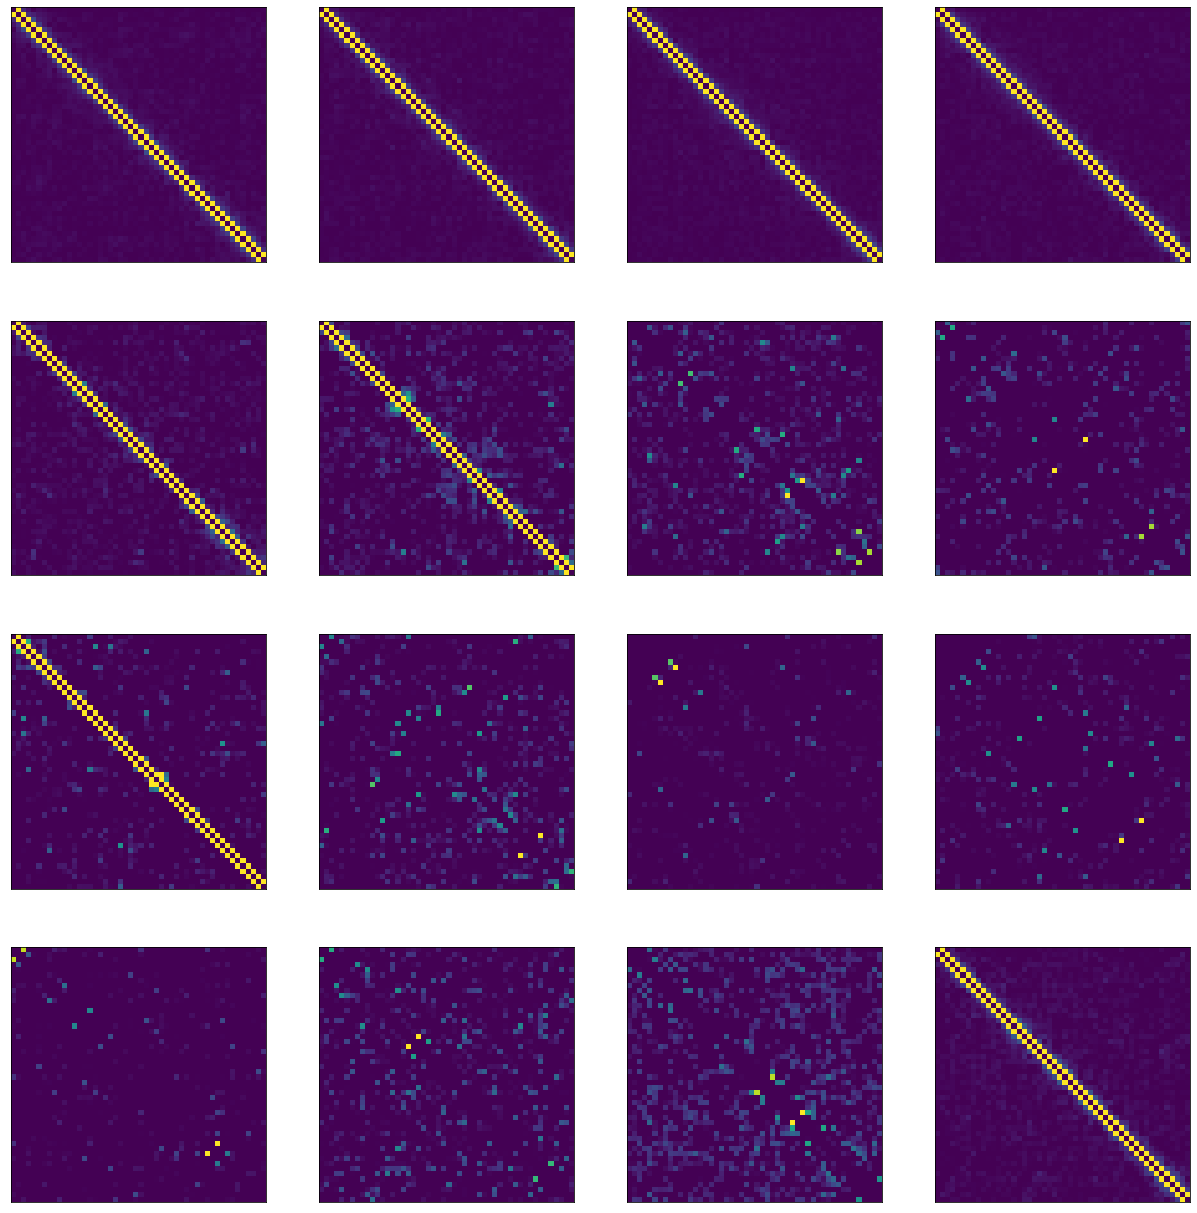

In [18]:
display_dictionary(W = W, figsize=[20,20])

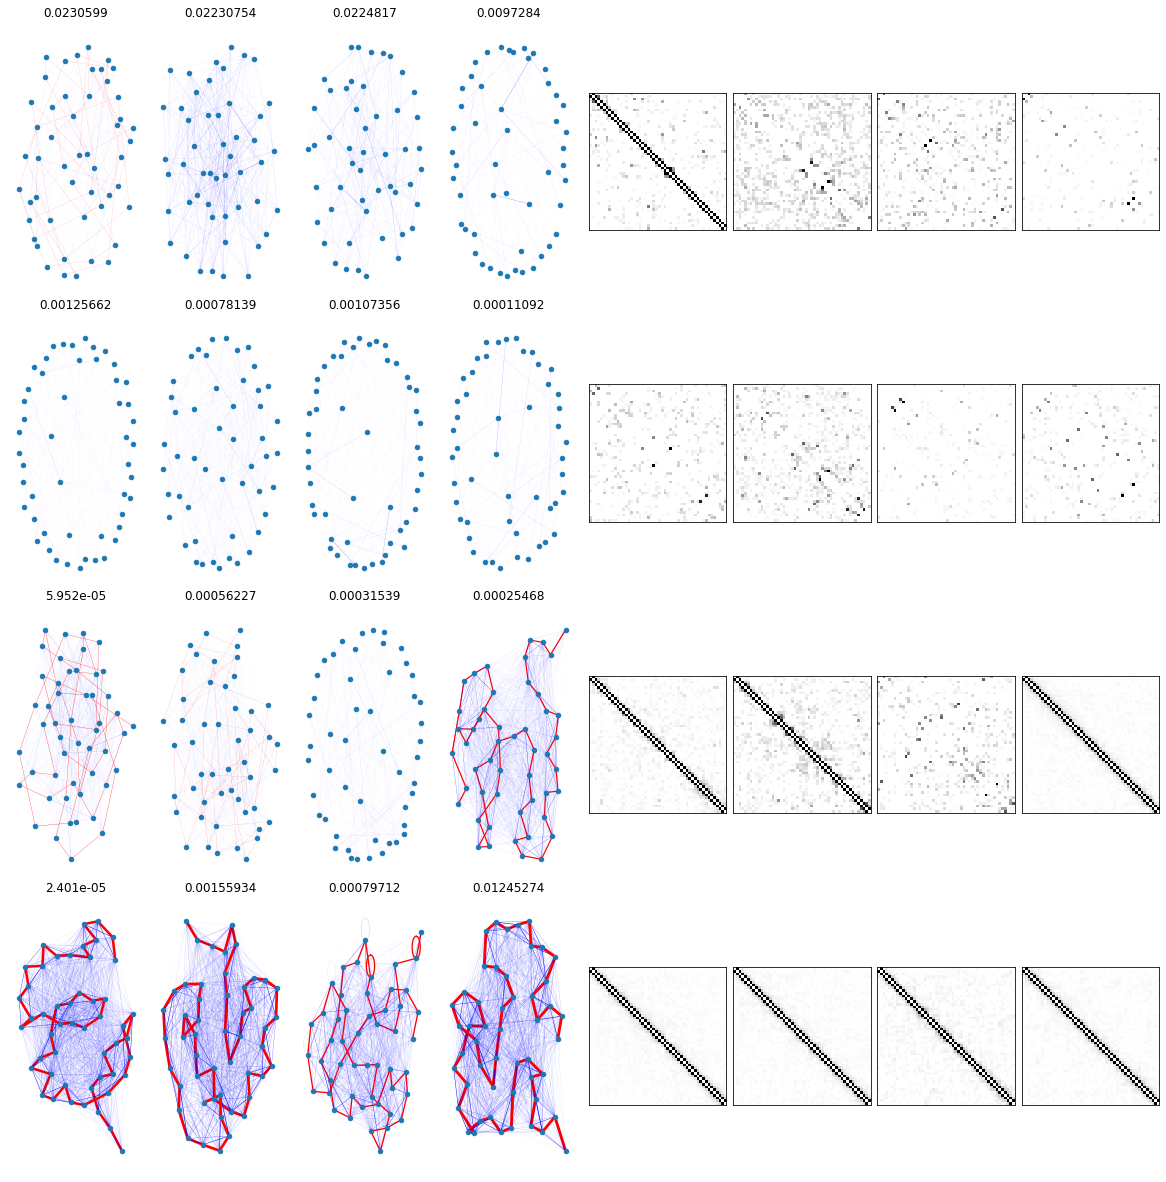

In [19]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 50, 
                       fig_size = [20,20], 
                       show_importance = False)

In [20]:
# SDL_BCD_filter
data_scale=10
results_dict_list_filter = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class_filter = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                       X_test = [X_test.T/data_scale, Y_test.T],
                                       n_components = r,
                                       xi = xi,
                                       L1_reg = [0,0,0],
                                       L2_reg = [0,0,0],
                                       nonnegativity = [True,True,False],
                                       full_dim = False)

        results_dict_new_filter = SDL_BCD_class_filter.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.87298445 -0.12699877 -0.20825311 -0.27546944  0.49774036 -0.0319775
  -0.02562305 -0.97833374  0.07773838 -0.11992875  0.40319611  0.7588105
  -0.45427268 -0.88021645 -0.4576259  -0.20855578  0.77081273]]


  1%|▍                                          | 2/200 [00:00<00:38,  5.14it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 0: Training loss --- [Data, Label, Total] = [596.442696.3, 1299.218514.3, 1299.218514.3]


  6%|██▌                                       | 12/200 [00:02<00:32,  5.70it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.635]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.862634.3, 1299.216628.3, 1299.216628.3]


 11%|████▌                                     | 22/200 [00:04<00:33,  5.30it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.659]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.179626.3, 1299.197935.3, 1299.197935.3]


 16%|██████▋                                   | 32/200 [00:06<00:34,  4.84it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.698]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.151960.3, 1299.138623.3, 1299.138623.3]


 21%|████████▊                                 | 42/200 [00:07<00:29,  5.39it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.167881.3, 1299.100854.3, 1299.100854.3]


 26%|██████████▉                               | 52/200 [00:09<00:29,  5.08it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.174041.3, 1299.096134.3, 1299.096134.3]


 31%|█████████████                             | 62/200 [00:11<00:27,  5.01it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.175371.3, 1299.095855.3, 1299.095855.3]


 36%|███████████████                           | 72/200 [00:13<00:23,  5.51it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.175495.3, 1299.095843.3, 1299.095843.3]


 41%|█████████████████▏                        | 82/200 [00:15<00:21,  5.53it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:22,  4.89it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:19,  5.13it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 56%|██████████████████████▊                  | 111/200 [00:20<00:18,  4.71it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 60%|████████████████████████▊                | 121/200 [00:22<00:21,  3.64it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 66%|██████████████████████████▊              | 131/200 [00:25<00:16,  4.08it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 71%|█████████████████████████████            | 142/200 [00:27<00:12,  4.80it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 76%|██████████████████████████████▉          | 151/200 [00:29<00:13,  3.64it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 80%|█████████████████████████████████        | 161/200 [00:34<00:24,  1.60it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 86%|███████████████████████████████████      | 171/200 [00:36<00:07,  3.81it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 90%|█████████████████████████████████████    | 181/200 [00:39<00:06,  2.91it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:41<00:01,  4.91it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


100%|█████████████████████████████████████████| 200/200 [00:44<00:00,  4.46it/s]


!!! pred_type filter
initial loading beta [[ 0.19278657  0.45106313  0.05836994 -0.5652937  -0.48587085 -0.09672599
   0.67142178 -0.54513146 -0.4984671  -0.64967801 -0.1018686  -0.41822573
   0.89202985 -0.78000239  0.82630223  0.73920536 -0.79511713]]


  1%|▍                                          | 2/200 [00:00<00:42,  4.71it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 0: Training loss --- [Data, Label, Total] = [594.188277.3, 1299.218671.3, 1299.218671.3]


  6%|██▌                                       | 12/200 [00:01<00:30,  6.23it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.634]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.850489.3, 1299.216749.3, 1299.216749.3]


 11%|████▌                                     | 22/200 [00:03<00:28,  6.21it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.66]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.179106.3, 1299.197190.3, 1299.197190.3]


 16%|██████▋                                   | 32/200 [00:05<00:27,  6.02it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.699]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.153772.3, 1299.136114.3, 1299.136114.3]


 21%|████████▊                                 | 42/200 [00:06<00:28,  5.63it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.168764.3, 1299.100176.3, 1299.100176.3]


 26%|██████████▋                               | 51/200 [00:08<00:28,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.174240.3, 1299.096082.3, 1299.096082.3]


 31%|█████████████                             | 62/200 [00:10<00:28,  4.93it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.175407.3, 1299.095852.3, 1299.095852.3]


 36%|███████████████                           | 72/200 [00:12<00:25,  5.00it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.175492.3, 1299.095843.3, 1299.095843.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:19,  6.17it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 46%|███████████████████▎                      | 92/200 [00:15<00:17,  6.10it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:16,  6.06it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 56%|██████████████████████▉                  | 112/200 [00:18<00:14,  5.99it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 61%|█████████████████████████                | 122/200 [00:20<00:13,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 66%|███████████████████████████              | 132/200 [00:22<00:12,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 71%|█████████████████████████████            | 142/200 [00:24<00:10,  5.32it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 76%|███████████████████████████████▏         | 152/200 [00:25<00:08,  5.62it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 81%|█████████████████████████████████▏       | 162/200 [00:27<00:07,  5.23it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 86%|███████████████████████████████████▎     | 172/200 [00:29<00:05,  5.38it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:31<00:03,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:33<00:01,  5.62it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


100%|█████████████████████████████████████████| 200/200 [00:34<00:00,  5.82it/s]


!!! pred_type filter
initial loading beta [[ 0.07128112  0.0949843  -0.16498329  0.46223607 -0.86315953  0.06688444
  -0.34241374  0.04222021  0.13464921 -0.92130243 -0.89379597  0.32603535
  -0.87822367  0.07880242  0.97553774 -0.46455676  0.97493962]]


  1%|▍                                          | 2/200 [00:00<00:38,  5.19it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 0: Training loss --- [Data, Label, Total] = [620.170493.3, 1299.219891.3, 1361.236941.3]


  6%|██▌                                       | 12/200 [00:02<00:47,  3.97it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.634]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.919787.3, 1299.220582.3, 1299.412560.3]


 11%|████▌                                     | 22/200 [00:04<00:33,  5.36it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.646]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.962119.3, 1299.213336.3, 1299.309548.3]


 16%|██████▋                                   | 32/200 [00:06<00:34,  4.82it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.663]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.621875.3, 1299.200802.3, 1299.262989.3]


 21%|████████▊                                 | 42/200 [00:08<00:31,  5.04it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.677]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.476172.3, 1299.186708.3, 1299.234325.3]


 26%|██████████▉                               | 52/200 [00:10<00:28,  5.11it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.686]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.442614.3, 1299.171719.3, 1299.215981.3]


 30%|████████████▊                             | 61/200 [00:12<00:32,  4.28it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.693]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.433735.3, 1299.157507.3, 1299.200881.3]


 36%|███████████████                           | 72/200 [00:16<00:34,  3.67it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.698]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.430606.3, 1299.145248.3, 1299.188309.3]


 41%|█████████████████▏                        | 82/200 [00:18<00:21,  5.41it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.702]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.429245.3, 1299.135358.3, 1299.178283.3]


 46%|███████████████████▎                      | 92/200 [00:20<00:19,  5.66it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.704]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.428547.3, 1299.127694.3, 1299.170549.3]


 51%|████████████████████▉                    | 102/200 [00:21<00:16,  5.84it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.705]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.428121.3, 1299.121835.3, 1299.164647.3]


 56%|██████████████████████▊                  | 111/200 [00:23<00:16,  5.25it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.706]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.427816.3, 1299.117339.3, 1299.160120.3]


 61%|█████████████████████████                | 122/200 [00:25<00:14,  5.29it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.706]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.427571.3, 1299.113873.3, 1299.156630.3]


 66%|██████████████████████████▊              | 131/200 [00:26<00:12,  5.67it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.427360.3, 1299.111184.3, 1299.153920.3]


 70%|████████████████████████████▉            | 141/200 [00:28<00:11,  5.11it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.427171.3, 1299.109069.3, 1299.151786.3]


 76%|███████████████████████████████▏         | 152/200 [00:30<00:09,  5.29it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.426999.3, 1299.107386.3, 1299.150086.3]


 81%|█████████████████████████████████▏       | 162/200 [00:32<00:07,  5.39it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.426844.3, 1299.106032.3, 1299.148717.3]


 86%|███████████████████████████████████▎     | 172/200 [00:34<00:05,  5.50it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.426704.3, 1299.104928.3, 1299.147598.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:36<00:03,  5.38it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.426577.3, 1299.104018.3, 1299.146675.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:38<00:01,  4.73it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.426463.3, 1299.103259.3, 1299.145905.3]


100%|█████████████████████████████████████████| 200/200 [00:39<00:00,  5.06it/s]


!!! pred_type filter
initial loading beta [[ 0.49786356 -0.44187213 -0.42795005 -0.07958053  0.42109502 -0.02428063
  -0.434192    0.12684652 -0.53951724  0.10475244 -0.33400439  0.90694451
  -0.59647226  0.91098727 -0.64936726 -0.75564612 -0.82838781]]


  1%|▍                                          | 2/200 [00:00<00:43,  4.54it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 0: Training loss --- [Data, Label, Total] = [617.519906.3, 1299.219733.3, 1360.971723.3]


  6%|██▎                                       | 11/200 [00:02<00:34,  5.48it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.633]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.981297.3, 1299.220455.3, 1299.418584.3]


 10%|████▍                                     | 21/200 [00:03<00:39,  4.55it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.644]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.960394.3, 1299.214287.3, 1299.310327.3]


 16%|██████▋                                   | 32/200 [00:06<00:32,  5.22it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.659]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.624178.3, 1299.203832.3, 1299.266249.3]


 21%|████████▊                                 | 42/200 [00:07<00:27,  5.77it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.671]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.481832.3, 1299.191625.3, 1299.239808.3]


 26%|██████████▉                               | 52/200 [00:09<00:27,  5.33it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.682]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.446245.3, 1299.178205.3, 1299.222830.3]


 31%|█████████████                             | 62/200 [00:11<00:26,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.689]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.436013.3, 1299.164673.3, 1299.208274.3]


 36%|███████████████                           | 72/200 [00:13<00:25,  4.97it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.695]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.432089.3, 1299.152262.3, 1299.195471.3]


 40%|█████████████████                         | 81/200 [00:15<00:25,  4.75it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.699]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.430206.3, 1299.141668.3, 1299.184689.3]


 46%|███████████████████▎                      | 92/200 [00:17<00:21,  4.91it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.702]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.429137.3, 1299.133075.3, 1299.175988.3]


 51%|████████████████████▉                    | 102/200 [00:19<00:20,  4.87it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.704]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.428443.3, 1299.126300.3, 1299.169144.3]


 56%|██████████████████████▊                  | 111/200 [00:20<00:17,  4.97it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.705]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.427952.3, 1299.121018.3, 1299.163814.3]


 60%|████████████████████████▊                | 121/200 [00:23<00:17,  4.39it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.706]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.427580.3, 1299.116895.3, 1299.159653.3]


 66%|███████████████████████████              | 132/200 [00:25<00:14,  4.54it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.706]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.427286.3, 1299.113671.3, 1299.156400.3]


 71%|█████████████████████████████            | 142/200 [00:27<00:09,  6.07it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.427047.3, 1299.111121.3, 1299.153826.3]


 76%|███████████████████████████████▏         | 152/200 [00:28<00:07,  6.02it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.426848.3, 1299.109094.3, 1299.151778.3]


 81%|█████████████████████████████████▏       | 162/200 [00:30<00:06,  6.05it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.426678.3, 1299.107466.3, 1299.150134.3]


 86%|███████████████████████████████████▎     | 172/200 [00:31<00:04,  6.18it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.426531.3, 1299.106142.3, 1299.148795.3]


 90%|█████████████████████████████████████    | 181/200 [00:33<00:03,  4.88it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.426400.3, 1299.105052.3, 1299.147692.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:36<00:03,  2.86it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.426283.3, 1299.104148.3, 1299.146777.3]


100%|█████████████████████████████████████████| 200/200 [00:38<00:00,  5.19it/s]


!!! pred_type filter
initial loading beta [[ 0.2061754  -0.36488297 -0.84674937  0.15492409 -0.20178068  0.45305696
   0.05673185  0.99294981 -0.20049892 -0.18286265  0.4009254  -0.18595369
  -0.48526894  0.16273641 -0.46904167  0.05597178  0.12261129]]


  1%|▍                                          | 2/200 [00:00<00:35,  5.56it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 0: Training loss --- [Data, Label, Total] = [787.629228.3, 1299.228495.3, 2086.857723.3]


  6%|██▌                                       | 12/200 [00:02<00:33,  5.67it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.629]
--- Iteration 10: Training loss --- [Data, Label, Total] = [2.069460.3, 1299.234834.3, 1301.304295.3]


 10%|████▍                                     | 21/200 [00:03<00:32,  5.57it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.629]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.673236.3, 1299.234489.3, 1299.907725.3]


 16%|██████▋                                   | 32/200 [00:05<00:29,  5.70it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.63]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.530151.3, 1299.234248.3, 1299.764400.3]


 20%|████████▌                                 | 41/200 [00:07<00:34,  4.59it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.63]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.487300.3, 1299.234030.3, 1299.721329.3]


 26%|██████████▋                               | 51/200 [00:09<00:32,  4.57it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.467052.3, 1299.233814.3, 1299.700866.3]


 31%|█████████████                             | 62/200 [00:11<00:27,  5.01it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.632]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.455323.3, 1299.233596.3, 1299.688919.3]


 36%|███████████████                           | 72/200 [00:13<00:25,  5.01it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.633]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.447794.3, 1299.233373.3, 1299.681167.3]


 41%|█████████████████▏                        | 82/200 [00:15<00:21,  5.45it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.633]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.442629.3, 1299.233181.3, 1299.675810.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:18,  5.77it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.634]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.438925.3, 1299.232956.3, 1299.671881.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:17,  5.70it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.635]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.436178.3, 1299.232726.3, 1299.668904.3]


 56%|██████████████████████▉                  | 112/200 [00:20<00:15,  5.56it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.635]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.434083.3, 1299.232491.3, 1299.666574.3]


 61%|█████████████████████████                | 122/200 [00:22<00:15,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.636]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.432453.3, 1299.232251.3, 1299.664704.3]


 66%|███████████████████████████              | 132/200 [00:23<00:11,  5.84it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.637]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.431162.3, 1299.232006.3, 1299.663167.3]


 71%|█████████████████████████████            | 142/200 [00:25<00:09,  5.93it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.637]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.430124.3, 1299.231756.3, 1299.661880.3]


 76%|███████████████████████████████▏         | 152/200 [00:27<00:09,  5.18it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.638]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.429280.3, 1299.231500.3, 1299.660781.3]


 81%|█████████████████████████████████▏       | 162/200 [00:29<00:07,  5.01it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.639]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.428586.3, 1299.231240.3, 1299.659827.3]


 86%|███████████████████████████████████      | 171/200 [00:30<00:06,  4.69it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.64]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.428009.3, 1299.230975.3, 1299.658984.3]


 90%|█████████████████████████████████████    | 181/200 [00:32<00:04,  4.33it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.64]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.427525.3, 1299.230705.3, 1299.658230.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:35<00:01,  4.82it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.641]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.427115.3, 1299.230429.3, 1299.657544.3]


100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.46it/s]


!!! pred_type filter
initial loading beta [[ 0.04419613  0.99735703 -0.46177261  0.8046962  -0.62695297  0.48259046
   0.49366617 -0.36449104 -0.18115582  0.22316142  0.69049994  0.98731819
  -0.3496586  -0.25959866  0.69993979 -0.80596946 -0.67700406]]


  1%|▍                                          | 2/200 [00:00<00:34,  5.70it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 0: Training loss --- [Data, Label, Total] = [779.267922.3, 1299.228353.3, 2078.496275.3]


  6%|██▌                                       | 12/200 [00:01<00:32,  5.85it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.63]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.824604.3, 1299.234528.3, 1301.059132.3]


 11%|████▌                                     | 22/200 [00:03<00:31,  5.72it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.642763.3, 1299.234094.3, 1299.876857.3]


 16%|██████▋                                   | 32/200 [00:05<00:31,  5.42it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.632]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.514994.3, 1299.233825.3, 1299.748819.3]


 21%|████████▊                                 | 42/200 [00:07<00:29,  5.45it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.633]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.474595.3, 1299.233590.3, 1299.708185.3]


 26%|██████████▉                               | 52/200 [00:09<00:29,  5.05it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.633]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.455830.3, 1299.233361.3, 1299.689190.3]


 31%|█████████████                             | 62/200 [00:11<00:25,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.634]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.445301.3, 1299.233165.3, 1299.678465.3]


 36%|███████████████                           | 72/200 [00:12<00:23,  5.44it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.635]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.438793.3, 1299.232936.3, 1299.671729.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:20,  5.63it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.636]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.434546.3, 1299.232703.3, 1299.667250.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:19,  5.55it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.636]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.431677.3, 1299.232465.3, 1299.664142.3]


 50%|████████████████████▋                    | 101/200 [00:18<00:29,  3.31it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.637]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.429689.3, 1299.232222.3, 1299.661911.3]


 56%|██████████████████████▉                  | 112/200 [00:21<00:19,  4.62it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.638]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.428285.3, 1299.231974.3, 1299.660259.3]


 60%|████████████████████████▊                | 121/200 [00:22<00:15,  4.97it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.639]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.427278.3, 1299.231720.3, 1299.658998.3]


 66%|███████████████████████████              | 132/200 [00:24<00:12,  5.65it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.639]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.426544.3, 1299.231462.3, 1299.658006.3]


 71%|█████████████████████████████            | 142/200 [00:26<00:10,  5.45it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.64]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.426003.3, 1299.231199.3, 1299.657202.3]


 76%|███████████████████████████████▏         | 152/200 [00:28<00:08,  5.39it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.641]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.425600.3, 1299.230931.3, 1299.656531.3]


 81%|█████████████████████████████████▏       | 162/200 [00:30<00:07,  5.03it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.641]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.425295.3, 1299.230659.3, 1299.655953.3]


 86%|███████████████████████████████████      | 171/200 [00:31<00:05,  4.93it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.642]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.425061.3, 1299.230381.3, 1299.655442.3]


 90%|█████████████████████████████████████    | 181/200 [00:33<00:04,  4.45it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.643]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.424881.3, 1299.230099.3, 1299.654979.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:36<00:01,  4.61it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.644]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.424739.3, 1299.229812.3, 1299.654550.3]


100%|█████████████████████████████████████████| 200/200 [00:37<00:00,  5.29it/s]


!!! pred_type filter
initial loading beta [[-0.41882469  0.90414607  0.48485571  0.18958768  0.99071297  0.46343182
  -0.73555295 -0.6094962  -0.54219317 -0.20260038  0.54270743  0.55122367
  -0.60877983  0.37937626 -0.23068406  0.93290883 -0.0784799 ]]


  1%|▍                                          | 2/200 [00:00<00:35,  5.56it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.63]
--- Iteration 0: Training loss --- [Data, Label, Total] = [722.626846.3, 1299.240586.3, 4912.374816.3]


  6%|██▌                                       | 12/200 [00:01<00:30,  6.06it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.588]
--- Iteration 10: Training loss --- [Data, Label, Total] = [2.842666.3, 1299.243031.3, 1313.456360.3]


 11%|████▌                                     | 22/200 [00:03<00:29,  5.98it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.586]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.533632.3, 1299.243025.3, 1301.911185.3]


 16%|██████▋                                   | 32/200 [00:05<00:28,  5.90it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.586]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.457731.3, 1299.243019.3, 1301.531673.3]


 21%|████████▊                                 | 42/200 [00:06<00:27,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.586]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.447258.3, 1299.243004.3, 1301.479295.3]


 26%|██████████▉                               | 52/200 [00:08<00:24,  5.96it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.586]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.444129.3, 1299.242998.3, 1301.463643.3]


 31%|█████████████                             | 62/200 [00:10<00:24,  5.68it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.586]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.442665.3, 1299.242993.3, 1301.456319.3]


 36%|███████████████                           | 72/200 [00:11<00:24,  5.32it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.586]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.441775.3, 1299.242988.3, 1301.451863.3]


 41%|█████████████████▏                        | 82/200 [00:13<00:22,  5.28it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.586]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.441126.3, 1299.242982.3, 1301.448615.3]


 46%|███████████████████                       | 91/200 [00:15<00:22,  4.88it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.440589.3, 1299.242977.3, 1301.445924.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:20,  4.81it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.440107.3, 1299.242972.3, 1301.443508.3]


 56%|██████████████████████▊                  | 111/200 [00:19<00:20,  4.40it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.439655.3, 1299.242966.3, 1301.441241.3]


 61%|█████████████████████████                | 122/200 [00:22<00:22,  3.49it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.439221.3, 1299.242961.3, 1301.439067.3]


 66%|███████████████████████████              | 132/200 [00:24<00:14,  4.55it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.438801.3, 1299.242956.3, 1301.436960.3]


 71%|█████████████████████████████            | 142/200 [00:26<00:09,  6.06it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.438391.3, 1299.242951.3, 1301.434905.3]


 76%|███████████████████████████████▏         | 152/200 [00:28<00:08,  5.43it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.437990.3, 1299.242945.3, 1301.432896.3]


 81%|█████████████████████████████████▏       | 162/200 [01:17<01:13,  1.93s/it]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.437598.3, 1299.242940.3, 1301.430930.3]


 86%|███████████████████████████████████▎     | 172/200 [01:20<00:08,  3.23it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.437214.3, 1299.242935.3, 1301.429006.3]


 90%|█████████████████████████████████████    | 181/200 [01:22<00:05,  3.51it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.436838.3, 1299.242930.3, 1301.427122.3]


 96%|███████████████████████████████████████▎ | 192/200 [01:26<00:01,  4.44it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.436471.3, 1299.242924.3, 1301.425279.3]


100%|█████████████████████████████████████████| 200/200 [01:28<00:00,  2.27it/s]


!!! pred_type filter
initial loading beta [[-0.62664438  0.74901893  0.61407706 -0.76116784  0.20554194 -0.69992901
   0.08251102  0.27234942  0.5180115   0.91597716  0.81715153  0.1071901
   0.54179296 -0.7110852   0.38703496 -0.29720676 -0.47909948]]


  1%|▍                                          | 2/200 [00:00<00:36,  5.36it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.634]
--- Iteration 0: Training loss --- [Data, Label, Total] = [730.050429.3, 1299.240422.3, 4949.492566.3]


  6%|██▌                                       | 12/200 [00:02<00:35,  5.32it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.6]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.742766.3, 1299.242948.3, 1317.956779.3]


 11%|████▌                                     | 22/200 [00:03<00:30,  5.91it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.585929.3, 1299.242918.3, 1302.172564.3]


 16%|██████▋                                   | 32/200 [00:05<00:31,  5.30it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.464916.3, 1299.242909.3, 1301.567487.3]


 21%|████████▊                                 | 42/200 [00:08<00:40,  3.88it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.447603.3, 1299.242902.3, 1301.480916.3]


 26%|██████████▉                               | 52/200 [00:10<00:26,  5.53it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.443362.3, 1299.242896.3, 1301.459707.3]


 31%|█████████████                             | 62/200 [00:12<00:24,  5.60it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.441895.3, 1299.242889.3, 1301.452362.3]


 36%|███████████████                           | 72/200 [00:13<00:25,  5.10it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.441119.3, 1299.242883.3, 1301.448479.3]


 40%|█████████████████                         | 81/200 [00:15<00:25,  4.65it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.440535.3, 1299.242876.3, 1301.445552.3]


 46%|███████████████████▎                      | 92/200 [00:17<00:21,  4.95it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.440014.3, 1299.242870.3, 1301.442942.3]


 50%|████████████████████▋                    | 101/200 [00:19<00:20,  4.82it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.439522.3, 1299.242864.3, 1301.440471.3]


 56%|██████████████████████▉                  | 112/200 [00:21<00:17,  5.03it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.439046.3, 1299.242857.3, 1301.438087.3]


 60%|████████████████████████▊                | 121/200 [00:23<00:17,  4.52it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.438584.3, 1299.242851.3, 1301.435772.3]


 66%|██████████████████████████▊              | 131/200 [00:25<00:14,  4.87it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.438135.3, 1299.242845.3, 1301.433519.3]


 71%|█████████████████████████████            | 142/200 [00:27<00:11,  4.89it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.437697.3, 1299.242838.3, 1301.431325.3]


 76%|██████████████████████████████▉          | 151/200 [00:29<00:10,  4.69it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.437272.3, 1299.242832.3, 1301.429191.3]


 81%|█████████████████████████████████▏       | 162/200 [00:31<00:08,  4.74it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.436858.3, 1299.242825.3, 1301.427114.3]


 86%|███████████████████████████████████▎     | 172/200 [00:33<00:05,  4.74it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.436455.3, 1299.242819.3, 1301.425094.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:36<00:03,  4.77it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.436063.3, 1299.242812.3, 1301.423130.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:37<00:01,  4.89it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.435683.3, 1299.242806.3, 1301.421220.3]


100%|█████████████████████████████████████████| 200/200 [00:39<00:00,  5.06it/s]


!!! pred_type filter
initial loading beta [[ 0.19270816  0.48612106  0.90382991  0.47376158 -0.35509092 -0.71666481
  -0.93528311  0.58811366 -0.5809061   0.41203118 -0.07068439 -0.10761915
  -0.88611596 -0.39214625  0.36902509  0.86111619  0.26675984]]


  1%|▍                                          | 2/200 [00:00<00:37,  5.28it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.548]
--- Iteration 0: Training loss --- [Data, Label, Total] = [411.366178.3, 1299.245214.3, 5412.906991.3]


  6%|██▌                                       | 12/200 [00:01<00:31,  5.94it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.569]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.220168.3, 1299.245240.3, 1311.446915.3]


 11%|████▌                                     | 22/200 [00:03<00:30,  5.86it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.57]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.186078.3, 1299.245240.3, 1311.106019.3]


 16%|██████▋                                   | 32/200 [00:05<00:27,  6.03it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.571]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.185738.3, 1299.245240.3, 1311.102620.3]


 21%|████████▊                                 | 42/200 [00:06<00:27,  5.75it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.571]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.185500.3, 1299.245240.3, 1311.100245.3]


 26%|██████████▉                               | 52/200 [00:08<00:26,  5.60it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.572]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.185287.3, 1299.245240.3, 1311.098113.3]


 30%|████████████▊                             | 61/200 [00:10<00:28,  4.94it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.573]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.185084.3, 1299.245240.3, 1311.096081.3]


 36%|███████████████                           | 72/200 [00:12<00:26,  4.87it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.574]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.184866.3, 1299.245240.3, 1311.093904.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:24,  4.87it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.574]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.184676.3, 1299.245240.3, 1311.091996.3]


 46%|███████████████████▎                      | 92/200 [00:17<00:36,  2.92it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.575]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.184484.3, 1299.245240.3, 1311.090076.3]


 51%|████████████████████▉                    | 102/200 [00:19<00:23,  4.23it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.576]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.184263.3, 1299.245240.3, 1311.087865.3]


 56%|██████████████████████▉                  | 112/200 [00:21<00:14,  5.96it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.576]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.184068.3, 1299.245239.3, 1311.085923.3]


 61%|█████████████████████████                | 122/200 [00:22<00:12,  6.04it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.577]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.183857.3, 1299.245239.3, 1311.083807.3]


 66%|███████████████████████████              | 132/200 [00:24<00:11,  5.68it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.577]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.183652.3, 1299.245239.3, 1311.081754.3]


 71%|█████████████████████████████            | 142/200 [00:26<00:10,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.578]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.183429.3, 1299.245239.3, 1311.079528.3]


 76%|███████████████████████████████▏         | 152/200 [00:27<00:08,  5.62it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.578]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.183209.3, 1299.245239.3, 1311.077330.3]


 81%|█████████████████████████████████▏       | 162/200 [00:29<00:06,  5.74it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.579]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.182935.3, 1299.245239.3, 1311.074584.3]


 86%|███████████████████████████████████▎     | 172/200 [00:31<00:05,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.579]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.182493.3, 1299.245239.3, 1311.070165.3]


 90%|█████████████████████████████████████    | 181/200 [00:32<00:03,  5.10it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.58]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.182065.3, 1299.245239.3, 1311.065890.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:35<00:01,  5.44it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.58]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.181641.3, 1299.245239.3, 1311.061650.3]


100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.49it/s]


!!! pred_type filter
initial loading beta [[ 0.99164574 -0.51798195 -0.03371105 -0.68667969  0.38416623  0.98438974
  -0.560292   -0.34827338 -0.23978104  0.01143528  0.65986432  0.71357315
  -0.36719401 -0.76341502  0.19590863 -0.51614003  0.08308639]]


  1%|▍                                          | 2/200 [00:00<00:40,  4.87it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.549]
--- Iteration 0: Training loss --- [Data, Label, Total] = [410.620561.3, 1299.245245.3, 5405.450856.3]


  6%|██▌                                       | 12/200 [00:02<00:37,  5.04it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.546]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.720606.3, 1299.245247.3, 1316.451303.3]


 11%|████▌                                     | 22/200 [00:04<00:34,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.55]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.260179.3, 1299.245248.3, 1311.847035.3]


 16%|██████▋                                   | 32/200 [00:05<00:32,  5.18it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.554]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.198508.3, 1299.245248.3, 1311.230325.3]


 21%|████████▊                                 | 42/200 [00:07<00:29,  5.32it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.554]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.185211.3, 1299.245248.3, 1311.097354.3]


 26%|██████████▉                               | 52/200 [00:09<00:28,  5.27it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.555]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.181760.3, 1299.245247.3, 1311.062849.3]


 30%|████████████▊                             | 61/200 [00:11<00:30,  4.57it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.556]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.180404.3, 1299.245247.3, 1311.049291.3]


 36%|███████████████                           | 72/200 [00:13<00:24,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.557]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.180083.3, 1299.245247.3, 1311.046074.3]


 41%|█████████████████▏                        | 82/200 [00:15<00:22,  5.28it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.558]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.180537.3, 1299.245247.3, 1311.050615.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:20,  5.38it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.56]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.180783.3, 1299.245247.3, 1311.053081.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:17,  5.45it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.561]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.181107.3, 1299.245247.3, 1311.056318.3]


 56%|██████████████████████▉                  | 112/200 [00:20<00:15,  5.58it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.562]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.181430.3, 1299.245247.3, 1311.059543.3]


 61%|█████████████████████████                | 122/200 [00:22<00:16,  4.79it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.563]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.181738.3, 1299.245247.3, 1311.062632.3]


 66%|███████████████████████████              | 132/200 [00:24<00:14,  4.70it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.565]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.182017.3, 1299.245247.3, 1311.065417.3]


 71%|█████████████████████████████            | 142/200 [00:26<00:10,  5.46it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.566]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.182236.3, 1299.245247.3, 1311.067611.3]


 76%|███████████████████████████████▏         | 152/200 [00:28<00:10,  4.60it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.567]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.182397.3, 1299.245247.3, 1311.069215.3]


 80%|█████████████████████████████████        | 161/200 [00:30<00:08,  4.73it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.568]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.182511.3, 1299.245247.3, 1311.070359.3]


 86%|███████████████████████████████████▎     | 172/200 [00:32<00:05,  4.94it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.569]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.182273.3, 1299.245247.3, 1311.067978.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:34<00:03,  5.03it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.57]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.181165.3, 1299.245247.3, 1311.056896.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:36<00:01,  5.15it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.571]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.179696.3, 1299.245247.3, 1311.042204.3]


100%|█████████████████████████████████████████| 200/200 [00:37<00:00,  5.27it/s]

!!! pred_type filter


In [21]:
W = results_dict_new_filter['loading'][0]
coeff = results_dict_new_filter['loading'][1][0]
H = results_dict_new_filter['code']

In [22]:
coeff

array([-0.04161778,  0.0003437 ,  0.00023103,  0.00027535,  0.00025887,
        0.00025901,  0.0002397 ,  0.000288  ,  0.00030867,  0.00029256,
        0.00025655,  0.00030832,  0.0002802 ,  0.00935676,  0.00030033,
        0.00024102,  0.000285  ])

In [23]:
print('Accuracy: {}'.format(results_dict_new_filter['Accuracy']))
print('Training RRE: {}'.format(results_dict_new_filter['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new_filter['Relative_reconstruction_loss (test)']))

Accuracy: 0.5936
Training RRE: 0.9895049798225487
Testing RRE: 0.9999423860040404


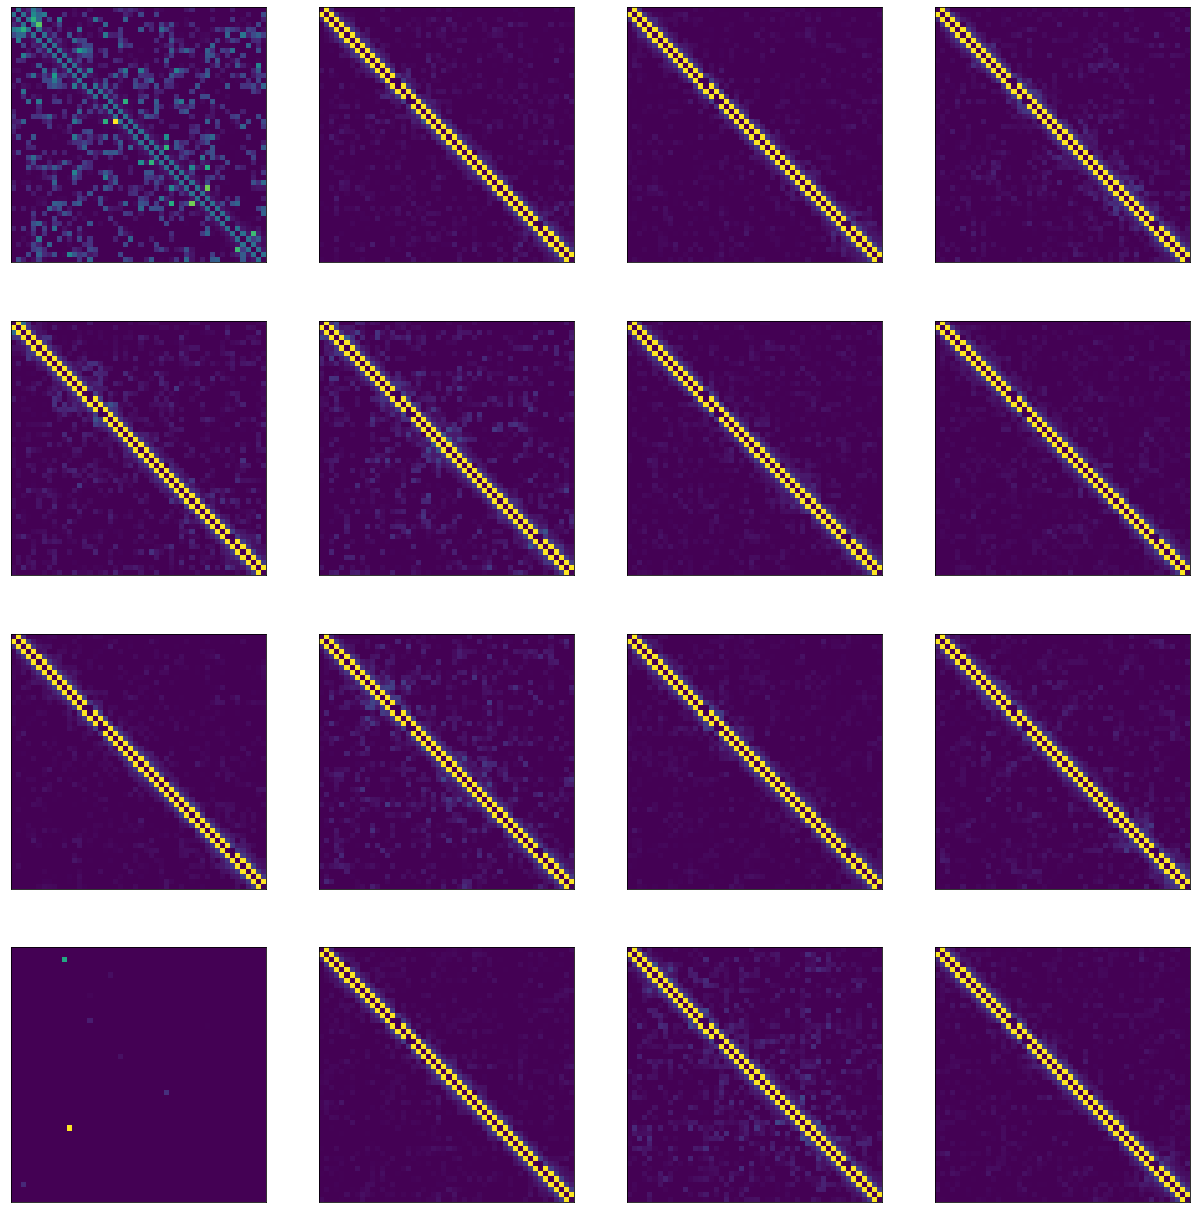

In [24]:
display_dictionary(W = W, figsize=[20,20])

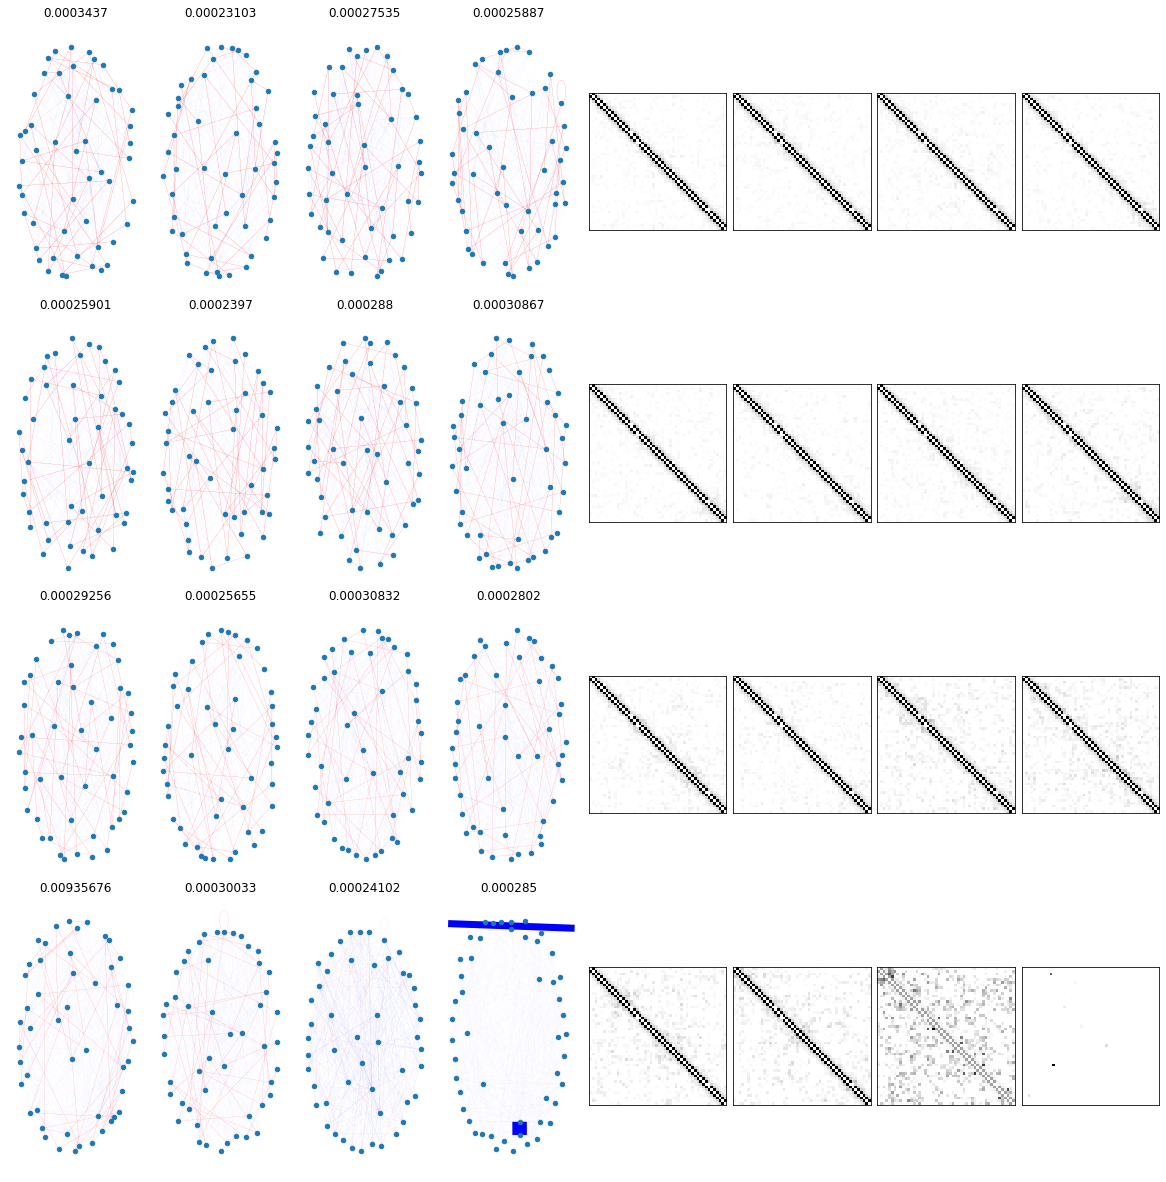

In [25]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 150, 
                       fig_size = [20,20], 
                       show_importance = True)

## 9 Dictionaries:

In [26]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  1%|▍                                         | 9/1000 [00:00<00:24, 40.19it/s]

iteration 0, reconstruction error 201127.620567


  2%|▋                                        | 17/1000 [00:00<00:25, 38.12it/s]

iteration 10, reconstruction error 83510.987340


  3%|█                                        | 27/1000 [00:00<00:24, 39.26it/s]

iteration 20, reconstruction error 86670.597997


  3%|█▎                                       | 32/1000 [00:00<00:24, 39.99it/s]

iteration 30, reconstruction error 89456.493063


  5%|██                                       | 49/1000 [00:01<00:29, 32.71it/s]

iteration 40, reconstruction error 89651.501841


  6%|██▎                                      | 57/1000 [00:01<00:26, 35.71it/s]

iteration 50, reconstruction error 89374.498914


  6%|██▌                                      | 61/1000 [00:01<00:25, 36.71it/s]

iteration 60, reconstruction error 88566.483286


  8%|███▏                                     | 78/1000 [00:02<00:27, 33.37it/s]

iteration 70, reconstruction error 86659.892737


  9%|███▌                                     | 87/1000 [00:02<00:24, 36.91it/s]

iteration 80, reconstruction error 82995.888220


 10%|███▉                                     | 96/1000 [00:02<00:22, 39.52it/s]

iteration 90, reconstruction error 77814.265549


 11%|████▏                                   | 106/1000 [00:03<00:24, 36.02it/s]

iteration 100, reconstruction error 74112.469214


 12%|████▌                                   | 115/1000 [00:03<00:25, 34.50it/s]

iteration 110, reconstruction error 73129.403945


 13%|█████▏                                  | 129/1000 [00:03<00:22, 39.05it/s]

iteration 120, reconstruction error 72642.051237


 14%|█████▌                                  | 138/1000 [00:03<00:21, 39.84it/s]

iteration 130, reconstruction error 72308.842401


 14%|█████▋                                  | 143/1000 [00:04<00:28, 30.40it/s]

iteration 140, reconstruction error 72076.006747


 16%|██████▏                                 | 155/1000 [00:04<00:25, 32.53it/s]

iteration 150, reconstruction error 71907.723517


 17%|██████▊                                 | 169/1000 [00:04<00:22, 37.75it/s]

iteration 160, reconstruction error 71780.644291


 18%|███████▏                                | 179/1000 [00:05<00:20, 40.03it/s]

iteration 170, reconstruction error 71680.502752


 19%|███████▌                                | 189/1000 [00:05<00:19, 42.59it/s]

iteration 180, reconstruction error 71599.385473
iteration 190, reconstruction error 71533.031704


 20%|████████▏                               | 205/1000 [00:06<00:44, 17.67it/s]

iteration 200, reconstruction error 71478.619054


 22%|████████▊                               | 219/1000 [00:07<00:25, 30.70it/s]

iteration 210, reconstruction error 71433.749401


 23%|█████████▏                              | 230/1000 [00:07<00:19, 39.11it/s]

iteration 220, reconstruction error 71396.549915
iteration 230, reconstruction error 71365.294045


 25%|█████████▊                              | 246/1000 [00:07<00:17, 42.49it/s]

iteration 240, reconstruction error 71338.725766


 26%|██████████▏                             | 256/1000 [00:07<00:17, 42.26it/s]

iteration 250, reconstruction error 71315.815778


 27%|██████████▋                             | 266/1000 [00:08<00:18, 39.86it/s]

iteration 260, reconstruction error 71295.916357


 28%|███████████                             | 276/1000 [00:08<00:17, 41.39it/s]

iteration 270, reconstruction error 71278.420082


 29%|███████████▍                            | 286/1000 [00:08<00:16, 43.30it/s]

iteration 280, reconstruction error 71262.764612


 30%|███████████▊                            | 296/1000 [00:08<00:16, 42.63it/s]

iteration 290, reconstruction error 71248.636277


 31%|████████████▏                           | 306/1000 [00:09<00:16, 41.49it/s]

iteration 300, reconstruction error 71235.794079


 32%|████████████▋                           | 316/1000 [00:09<00:16, 41.84it/s]

iteration 310, reconstruction error 71224.093992


 32%|█████████████                           | 325/1000 [00:09<00:18, 35.96it/s]

iteration 320, reconstruction error 71213.384523


 34%|█████████████▍                          | 335/1000 [00:09<00:17, 38.67it/s]

iteration 330, reconstruction error 71203.496643


 34%|█████████████▊                          | 345/1000 [00:10<00:15, 41.58it/s]

iteration 340, reconstruction error 71194.330692


 36%|██████████████▍                         | 360/1000 [00:10<00:15, 41.68it/s]

iteration 350, reconstruction error 71185.770589


 36%|██████████████▌                         | 365/1000 [00:10<00:16, 38.89it/s]

iteration 360, reconstruction error 71177.733310


 38%|███████████████▏                        | 379/1000 [00:10<00:16, 38.48it/s]

iteration 370, reconstruction error 71170.165521


 39%|███████████████▌                        | 389/1000 [00:11<00:14, 41.50it/s]

iteration 380, reconstruction error 71163.031943


 40%|███████████████▉                        | 399/1000 [00:11<00:14, 41.39it/s]

iteration 390, reconstruction error 71156.302483


 41%|████████████████▎                       | 409/1000 [00:11<00:13, 42.87it/s]

iteration 400, reconstruction error 71149.940212


 42%|████████████████▊                       | 419/1000 [00:11<00:13, 44.17it/s]

iteration 410, reconstruction error 71143.893137


 43%|█████████████████▏                      | 430/1000 [00:12<00:12, 46.94it/s]

iteration 420, reconstruction error 71138.131750


 44%|█████████████████▌                      | 440/1000 [00:12<00:12, 46.43it/s]

iteration 430, reconstruction error 71132.623854


 44%|█████████████████▊                      | 445/1000 [00:12<00:12, 45.88it/s]

iteration 440, reconstruction error 71127.340439


 46%|██████████████████▍                     | 460/1000 [00:12<00:11, 45.20it/s]

iteration 450, reconstruction error 71122.258041


 46%|██████████████████▌                     | 465/1000 [00:12<00:12, 43.28it/s]

iteration 460, reconstruction error 71117.354713


 48%|███████████████████▏                    | 480/1000 [00:13<00:11, 43.96it/s]

iteration 470, reconstruction error 71112.615689


 49%|███████████████████▌                    | 490/1000 [00:13<00:11, 44.77it/s]

iteration 480, reconstruction error 71108.035942


 50%|███████████████████▊                    | 495/1000 [00:13<00:11, 44.89it/s]

iteration 490, reconstruction error 71103.601175


 50%|████████████████████▏                   | 505/1000 [00:13<00:11, 42.03it/s]

iteration 500, reconstruction error 71099.302748


 52%|████████████████████▋                   | 516/1000 [00:14<00:11, 43.87it/s]

iteration 510, reconstruction error 71095.138210


 53%|█████████████████████                   | 526/1000 [00:14<00:10, 43.82it/s]

iteration 520, reconstruction error 71091.115231


 54%|█████████████████████▍                  | 536/1000 [00:14<00:10, 44.45it/s]

iteration 530, reconstruction error 71087.225927


 55%|█████████████████████▉                  | 547/1000 [00:14<00:10, 42.61it/s]

iteration 540, reconstruction error 71083.467624


 56%|██████████████████████▎                 | 557/1000 [00:15<00:10, 43.73it/s]

iteration 550, reconstruction error 71079.841060


 57%|██████████████████████▋                 | 567/1000 [00:15<00:10, 43.06it/s]

iteration 560, reconstruction error 71076.346275


 58%|███████████████████████                 | 578/1000 [00:15<00:09, 45.59it/s]

iteration 570, reconstruction error 71072.977447


 59%|███████████████████████▌                | 588/1000 [00:15<00:08, 46.22it/s]

iteration 580, reconstruction error 71069.731180


 60%|███████████████████████▉                | 598/1000 [00:15<00:09, 42.67it/s]

iteration 590, reconstruction error 71066.615769


 61%|████████████████████████▎               | 608/1000 [00:16<00:09, 39.24it/s]

iteration 600, reconstruction error 71063.626722


 62%|████████████████████████▋               | 617/1000 [00:16<00:09, 40.56it/s]

iteration 610, reconstruction error 71060.761152


 63%|█████████████████████████               | 627/1000 [00:16<00:08, 43.06it/s]

iteration 620, reconstruction error 71058.019655


 64%|█████████████████████████▍              | 637/1000 [00:16<00:08, 42.42it/s]

iteration 630, reconstruction error 71055.400252


 65%|█████████████████████████▉              | 647/1000 [00:17<00:08, 40.51it/s]

iteration 640, reconstruction error 71052.897902


 66%|██████████████████████████▎             | 657/1000 [00:17<00:08, 42.56it/s]

iteration 650, reconstruction error 71050.512113


 67%|██████████████████████████▋             | 667/1000 [00:17<00:07, 43.95it/s]

iteration 660, reconstruction error 71048.235456


 68%|███████████████████████████             | 677/1000 [00:17<00:07, 43.40it/s]

iteration 670, reconstruction error 71046.066289


 69%|███████████████████████████▍            | 687/1000 [00:18<00:07, 43.81it/s]

iteration 680, reconstruction error 71044.005085


 70%|███████████████████████████▉            | 697/1000 [00:18<00:07, 41.25it/s]

iteration 690, reconstruction error 71042.050505


 71%|████████████████████████████▎           | 707/1000 [00:18<00:06, 42.77it/s]

iteration 700, reconstruction error 71040.198713


 72%|████████████████████████████▋           | 717/1000 [00:18<00:06, 41.99it/s]

iteration 710, reconstruction error 71038.450823


 73%|█████████████████████████████           | 727/1000 [00:19<00:06, 43.46it/s]

iteration 720, reconstruction error 71036.804056


 74%|█████████████████████████████▍          | 737/1000 [00:19<00:06, 38.95it/s]

iteration 730, reconstruction error 71035.253728


 75%|█████████████████████████████▉          | 747/1000 [00:19<00:05, 42.22it/s]

iteration 740, reconstruction error 71033.799941


 76%|██████████████████████████████▎         | 758/1000 [00:19<00:05, 44.56it/s]

iteration 750, reconstruction error 71032.437029


 77%|██████████████████████████████▋         | 768/1000 [00:20<00:05, 43.09it/s]

iteration 760, reconstruction error 71031.153759


 78%|███████████████████████████████▏        | 779/1000 [00:20<00:04, 46.26it/s]

iteration 770, reconstruction error 71029.947318


 79%|███████████████████████████████▌        | 789/1000 [00:20<00:04, 45.76it/s]

iteration 780, reconstruction error 71028.813528


 80%|███████████████████████████████▉        | 799/1000 [00:20<00:04, 45.80it/s]

iteration 790, reconstruction error 71027.744579


 81%|████████████████████████████████▎       | 809/1000 [00:20<00:04, 45.70it/s]

iteration 800, reconstruction error 71026.732223


 82%|████████████████████████████████▊       | 819/1000 [00:21<00:03, 46.99it/s]

iteration 810, reconstruction error 71025.772714


 83%|█████████████████████████████████▏      | 829/1000 [00:21<00:03, 44.10it/s]

iteration 820, reconstruction error 71024.862522


 84%|█████████████████████████████████▌      | 839/1000 [00:21<00:03, 44.24it/s]

iteration 830, reconstruction error 71023.997460


 85%|█████████████████████████████████▉      | 849/1000 [00:21<00:03, 44.49it/s]

iteration 840, reconstruction error 71023.174206


 86%|██████████████████████████████████▎     | 859/1000 [00:22<00:03, 45.63it/s]

iteration 850, reconstruction error 71022.389257


 87%|██████████████████████████████████▊     | 870/1000 [00:22<00:02, 47.13it/s]

iteration 860, reconstruction error 71021.640050


 88%|███████████████████████████████████▏    | 880/1000 [00:22<00:02, 47.08it/s]

iteration 870, reconstruction error 71020.923742


 88%|███████████████████████████████████▍    | 885/1000 [00:22<00:02, 44.84it/s]

iteration 880, reconstruction error 71020.238416


 90%|████████████████████████████████████    | 900/1000 [00:22<00:02, 42.56it/s]

iteration 890, reconstruction error 71019.582381


 91%|████████████████████████████████████▍   | 910/1000 [00:23<00:01, 45.40it/s]

iteration 900, reconstruction error 71018.953131


 92%|████████████████████████████████████▌   | 915/1000 [00:23<00:01, 45.34it/s]

iteration 910, reconstruction error 71018.348920


 93%|█████████████████████████████████████   | 926/1000 [00:23<00:01, 46.76it/s]

iteration 920, reconstruction error 71017.768725


 94%|█████████████████████████████████████▍  | 936/1000 [00:23<00:01, 46.91it/s]

iteration 930, reconstruction error 71017.210388


 95%|█████████████████████████████████████▊  | 946/1000 [00:23<00:01, 46.70it/s]

iteration 940, reconstruction error 71016.671995


 96%|██████████████████████████████████████▏ | 956/1000 [00:24<00:00, 46.59it/s]

iteration 950, reconstruction error 71016.152695


 97%|██████████████████████████████████████▋ | 966/1000 [00:24<00:00, 46.34it/s]

iteration 960, reconstruction error 71015.651213


 98%|███████████████████████████████████████ | 977/1000 [00:24<00:00, 47.28it/s]

iteration 970, reconstruction error 71015.166192


 99%|███████████████████████████████████████▍| 987/1000 [00:24<00:00, 45.29it/s]

iteration 980, reconstruction error 71014.696594


100%|███████████████████████████████████████▉| 997/1000 [00:25<00:00, 42.46it/s]

iteration 990, reconstruction error 71014.241271


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.75it/s]




###########################
Shape of W_true: (2500, 9)
###########################




  0%|▏                                         | 4/1000 [00:00<00:27, 36.48it/s]

iteration 0, reconstruction error 195487.018305


  2%|▊                                        | 19/1000 [00:00<00:21, 44.88it/s]

iteration 10, reconstruction error 73039.281715


  3%|█▏                                       | 29/1000 [00:00<00:23, 42.13it/s]

iteration 20, reconstruction error 77585.063018


  4%|█▌                                       | 39/1000 [00:00<00:22, 42.92it/s]

iteration 30, reconstruction error 80545.719122


  5%|██                                       | 49/1000 [00:01<00:22, 42.32it/s]

iteration 40, reconstruction error 80655.695649


  6%|██▍                                      | 59/1000 [00:01<00:21, 44.27it/s]

iteration 50, reconstruction error 80571.753393


  7%|██▊                                      | 69/1000 [00:01<00:21, 44.16it/s]

iteration 60, reconstruction error 80345.106589


  8%|███▏                                     | 79/1000 [00:01<00:20, 44.92it/s]

iteration 70, reconstruction error 79802.541113


  9%|███▋                                     | 89/1000 [00:02<00:20, 44.52it/s]

iteration 80, reconstruction error 78585.784614


 10%|████                                     | 99/1000 [00:02<00:19, 45.90it/s]

iteration 90, reconstruction error 76094.931396


 11%|████▎                                   | 109/1000 [00:02<00:19, 44.72it/s]

iteration 100, reconstruction error 71737.703214


 12%|████▊                                   | 119/1000 [00:02<00:19, 45.29it/s]

iteration 110, reconstruction error 66502.306711


 13%|█████▏                                  | 129/1000 [00:02<00:19, 44.35it/s]

iteration 120, reconstruction error 64194.658609


 14%|█████▌                                  | 139/1000 [00:03<00:19, 45.10it/s]

iteration 130, reconstruction error 63633.470112


 15%|█████▉                                  | 149/1000 [00:03<00:19, 44.36it/s]

iteration 140, reconstruction error 63270.079822


 16%|██████▎                                 | 159/1000 [00:03<00:19, 42.98it/s]

iteration 150, reconstruction error 63006.238090


 17%|██████▊                                 | 169/1000 [00:03<00:19, 42.09it/s]

iteration 160, reconstruction error 62813.598999


 18%|███████▏                                | 179/1000 [00:04<00:18, 44.37it/s]

iteration 170, reconstruction error 62672.432207


 19%|███████▌                                | 189/1000 [00:04<00:17, 45.28it/s]

iteration 180, reconstruction error 62567.323545


 20%|███████▉                                | 199/1000 [00:04<00:17, 46.08it/s]

iteration 190, reconstruction error 62487.638122


 21%|████████▎                               | 209/1000 [00:04<00:18, 43.78it/s]

iteration 200, reconstruction error 62426.024295


 22%|████████▊                               | 219/1000 [00:05<00:18, 42.38it/s]

iteration 210, reconstruction error 62377.412157


 23%|█████████▏                              | 229/1000 [00:05<00:17, 43.85it/s]

iteration 220, reconstruction error 62338.257224


 24%|█████████▌                              | 239/1000 [00:05<00:17, 43.58it/s]

iteration 230, reconstruction error 62306.106287


 25%|█████████▉                              | 249/1000 [00:05<00:16, 45.64it/s]

iteration 240, reconstruction error 62279.259805


 26%|██████████▎                             | 259/1000 [00:05<00:16, 44.97it/s]

iteration 250, reconstruction error 62256.569817


 27%|██████████▊                             | 269/1000 [00:06<00:16, 43.96it/s]

iteration 260, reconstruction error 62237.140885


 28%|███████████▏                            | 279/1000 [00:06<00:16, 44.39it/s]

iteration 270, reconstruction error 62220.287510


 29%|███████████▌                            | 289/1000 [00:06<00:16, 44.10it/s]

iteration 280, reconstruction error 62205.476219


 30%|███████████▉                            | 299/1000 [00:06<00:15, 45.22it/s]

iteration 290, reconstruction error 62192.276510


 31%|████████████▎                           | 309/1000 [00:07<00:14, 46.19it/s]

iteration 300, reconstruction error 62180.343453


 32%|████████████▊                           | 319/1000 [00:07<00:15, 45.37it/s]

iteration 310, reconstruction error 62169.452758


 33%|█████████████▏                          | 329/1000 [00:07<00:15, 43.04it/s]

iteration 320, reconstruction error 62159.450074


 34%|█████████████▌                          | 339/1000 [00:07<00:15, 42.85it/s]

iteration 330, reconstruction error 62150.203093


 35%|█████████████▉                          | 349/1000 [00:07<00:14, 43.51it/s]

iteration 340, reconstruction error 62141.588163


 36%|██████████████▎                         | 359/1000 [00:08<00:14, 43.24it/s]

iteration 350, reconstruction error 62133.498676


 37%|██████████████▊                         | 369/1000 [00:08<00:14, 44.43it/s]

iteration 360, reconstruction error 62125.861737


 38%|███████████████▏                        | 379/1000 [00:08<00:13, 45.42it/s]

iteration 370, reconstruction error 62118.614179


 39%|███████████████▌                        | 389/1000 [00:08<00:13, 45.61it/s]

iteration 380, reconstruction error 62111.737846


 40%|███████████████▉                        | 399/1000 [00:09<00:13, 44.93it/s]

iteration 390, reconstruction error 62105.204794


 41%|████████████████▎                       | 409/1000 [00:09<00:13, 44.43it/s]

iteration 400, reconstruction error 62098.977637


 42%|████████████████▊                       | 419/1000 [00:09<00:12, 44.88it/s]

iteration 410, reconstruction error 62093.004155


 43%|█████████████████▏                      | 429/1000 [00:09<00:12, 44.25it/s]

iteration 420, reconstruction error 62087.268248


 44%|█████████████████▌                      | 439/1000 [00:09<00:12, 44.09it/s]

iteration 430, reconstruction error 62081.779961


 45%|█████████████████▉                      | 449/1000 [00:10<00:13, 42.31it/s]

iteration 440, reconstruction error 62076.516317


 46%|██████████████████▎                     | 459/1000 [00:10<00:12, 42.13it/s]

iteration 450, reconstruction error 62071.477440


 47%|██████████████████▊                     | 470/1000 [00:10<00:11, 44.63it/s]

iteration 460, reconstruction error 62066.625323


 48%|███████████████████▏                    | 480/1000 [00:10<00:11, 45.13it/s]

iteration 470, reconstruction error 62061.938204


 48%|███████████████████▍                    | 485/1000 [00:11<00:11, 43.53it/s]

iteration 480, reconstruction error 62057.407863


 50%|████████████████████                    | 500/1000 [00:11<00:11, 44.08it/s]

iteration 490, reconstruction error 62053.022817


 50%|████████████████████▏                   | 505/1000 [00:11<00:11, 42.14it/s]

iteration 500, reconstruction error 62048.782864


 52%|████████████████████▊                   | 520/1000 [00:11<00:10, 44.20it/s]

iteration 510, reconstruction error 62044.674905


 52%|█████████████████████                   | 525/1000 [00:11<00:11, 42.07it/s]

iteration 520, reconstruction error 62040.700796


 54%|█████████████████████▍                  | 535/1000 [00:12<00:12, 38.55it/s]

iteration 530, reconstruction error 62036.863047


 55%|██████████████████████                  | 550/1000 [00:12<00:10, 42.66it/s]

iteration 540, reconstruction error 62033.161919


 56%|██████████████████████▏                 | 555/1000 [00:12<00:10, 41.11it/s]

iteration 550, reconstruction error 62029.595743


 56%|██████████████████████▌                 | 565/1000 [00:12<00:10, 42.95it/s]

iteration 560, reconstruction error 62026.170569


 57%|███████████████████████                 | 575/1000 [00:13<00:10, 41.96it/s]

iteration 570, reconstruction error 62022.872572


 58%|███████████████████████▍                | 585/1000 [00:13<00:10, 41.35it/s]

iteration 580, reconstruction error 62019.701593


 60%|███████████████████████▊                | 595/1000 [00:13<00:09, 41.76it/s]

iteration 590, reconstruction error 62016.646692


 61%|████████████████████████▍               | 610/1000 [00:14<00:08, 43.50it/s]

iteration 600, reconstruction error 62013.703671


 62%|████████████████████████▌               | 615/1000 [00:14<00:09, 42.33it/s]

iteration 610, reconstruction error 62010.873626


 62%|█████████████████████████               | 625/1000 [00:14<00:08, 42.11it/s]

iteration 620, reconstruction error 62008.146477


 64%|█████████████████████████▌              | 640/1000 [00:14<00:08, 43.63it/s]

iteration 630, reconstruction error 62005.518615


 65%|██████████████████████████              | 650/1000 [00:14<00:07, 43.81it/s]

iteration 640, reconstruction error 62002.986377


 66%|██████████████████████████▍             | 660/1000 [00:15<00:07, 44.39it/s]

iteration 650, reconstruction error 62000.549030


 66%|██████████████████████████▌             | 665/1000 [00:15<00:07, 43.30it/s]

iteration 660, reconstruction error 61998.201442


 68%|███████████████████████████             | 675/1000 [00:15<00:07, 42.21it/s]

iteration 670, reconstruction error 61995.941821


 69%|███████████████████████████▌            | 690/1000 [00:15<00:06, 44.66it/s]

iteration 680, reconstruction error 61993.768268


 70%|███████████████████████████▊            | 695/1000 [00:15<00:06, 44.24it/s]

iteration 690, reconstruction error 61991.673003


 71%|████████████████████████████▏           | 706/1000 [00:16<00:06, 43.76it/s]

iteration 700, reconstruction error 61989.654281


 72%|████████████████████████████▋           | 716/1000 [00:16<00:06, 45.38it/s]

iteration 710, reconstruction error 61987.707131


 73%|█████████████████████████████           | 726/1000 [00:16<00:06, 44.96it/s]

iteration 720, reconstruction error 61985.832143


 74%|█████████████████████████████▍          | 736/1000 [00:16<00:05, 44.99it/s]

iteration 730, reconstruction error 61984.023498


 75%|█████████████████████████████▉          | 747/1000 [00:17<00:05, 46.52it/s]

iteration 740, reconstruction error 61982.275275


 76%|██████████████████████████████▎         | 757/1000 [00:17<00:05, 44.51it/s]

iteration 750, reconstruction error 61980.582321


 77%|██████████████████████████████▋         | 767/1000 [00:17<00:05, 43.56it/s]

iteration 760, reconstruction error 61978.942280


 78%|███████████████████████████████         | 777/1000 [00:17<00:05, 44.18it/s]

iteration 770, reconstruction error 61977.351148


 79%|███████████████████████████████▍        | 787/1000 [00:18<00:05, 42.29it/s]

iteration 780, reconstruction error 61975.808677


 80%|███████████████████████████████▉        | 797/1000 [00:18<00:04, 43.03it/s]

iteration 790, reconstruction error 61974.313707


 81%|████████████████████████████████▎       | 807/1000 [00:18<00:04, 43.81it/s]

iteration 800, reconstruction error 61972.862224


 82%|████████████████████████████████▋       | 817/1000 [00:18<00:04, 42.73it/s]

iteration 810, reconstruction error 61971.450911


 83%|█████████████████████████████████       | 827/1000 [00:18<00:03, 44.39it/s]

iteration 820, reconstruction error 61970.079768


 84%|█████████████████████████████████▍      | 837/1000 [00:19<00:03, 45.04it/s]

iteration 830, reconstruction error 61968.745558


 85%|█████████████████████████████████▉      | 847/1000 [00:19<00:03, 44.36it/s]

iteration 840, reconstruction error 61967.445642


 86%|██████████████████████████████████▎     | 857/1000 [00:19<00:03, 44.97it/s]

iteration 850, reconstruction error 61966.176279


 87%|██████████████████████████████████▋     | 867/1000 [00:19<00:02, 44.34it/s]

iteration 860, reconstruction error 61964.933998


 88%|███████████████████████████████████     | 877/1000 [00:20<00:02, 43.21it/s]

iteration 870, reconstruction error 61963.717447


 89%|███████████████████████████████████▍    | 887/1000 [00:20<00:02, 43.85it/s]

iteration 880, reconstruction error 61962.525984


 90%|███████████████████████████████████▉    | 897/1000 [00:20<00:02, 45.85it/s]

iteration 890, reconstruction error 61961.357916


 91%|████████████████████████████████████▎   | 907/1000 [00:20<00:02, 44.62it/s]

iteration 900, reconstruction error 61960.212647


 92%|████████████████████████████████████▋   | 917/1000 [00:21<00:01, 44.54it/s]

iteration 910, reconstruction error 61959.087375


 93%|█████████████████████████████████████   | 927/1000 [00:21<00:01, 45.10it/s]

iteration 920, reconstruction error 61957.982377


 94%|█████████████████████████████████████▍  | 937/1000 [00:21<00:01, 45.33it/s]

iteration 930, reconstruction error 61956.898937


 95%|█████████████████████████████████████▉  | 947/1000 [00:21<00:01, 44.66it/s]

iteration 940, reconstruction error 61955.837112


 96%|██████████████████████████████████████▎ | 957/1000 [00:21<00:01, 42.97it/s]

iteration 950, reconstruction error 61954.797131


 97%|██████████████████████████████████████▋ | 967/1000 [00:22<00:00, 44.11it/s]

iteration 960, reconstruction error 61953.776382


 98%|███████████████████████████████████████ | 977/1000 [00:22<00:00, 42.92it/s]

iteration 970, reconstruction error 61952.772610


 99%|███████████████████████████████████████▍| 987/1000 [00:22<00:00, 44.47it/s]

iteration 980, reconstruction error 61951.785028


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 43.67it/s]

iteration 990, reconstruction error 61950.813612


###########################
Shape of W_false: (2500, 9)
###########################




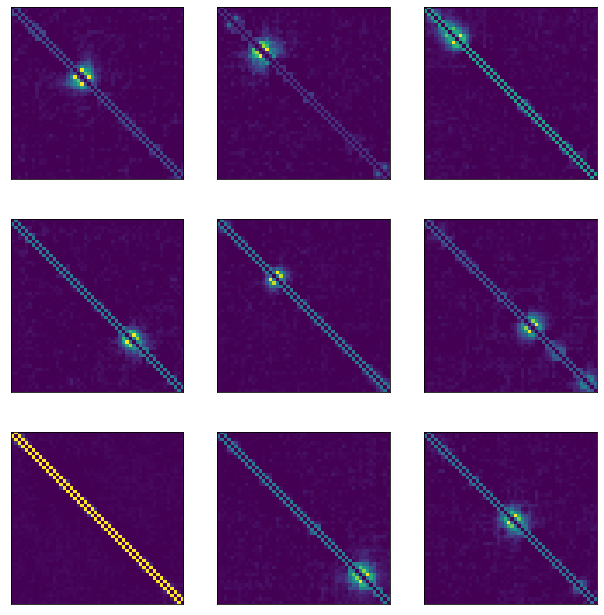

In [27]:
display_dictionary(W = W_true,
                   figsize = [10,10])

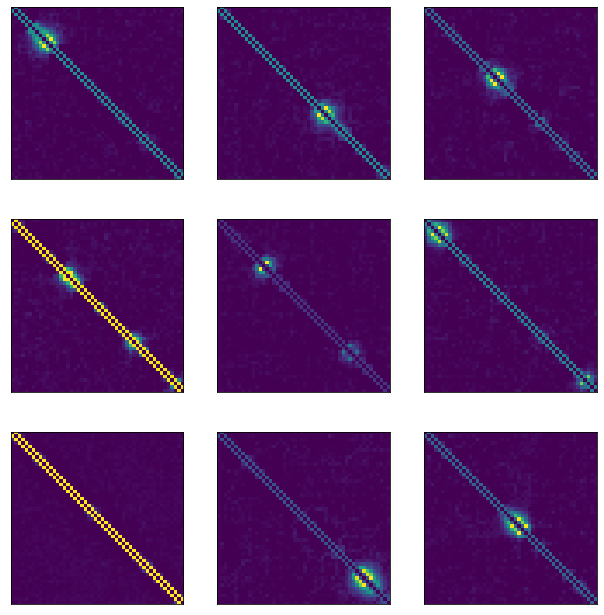

In [28]:
display_dictionary(W = W_false,
                   figsize = [10,10])

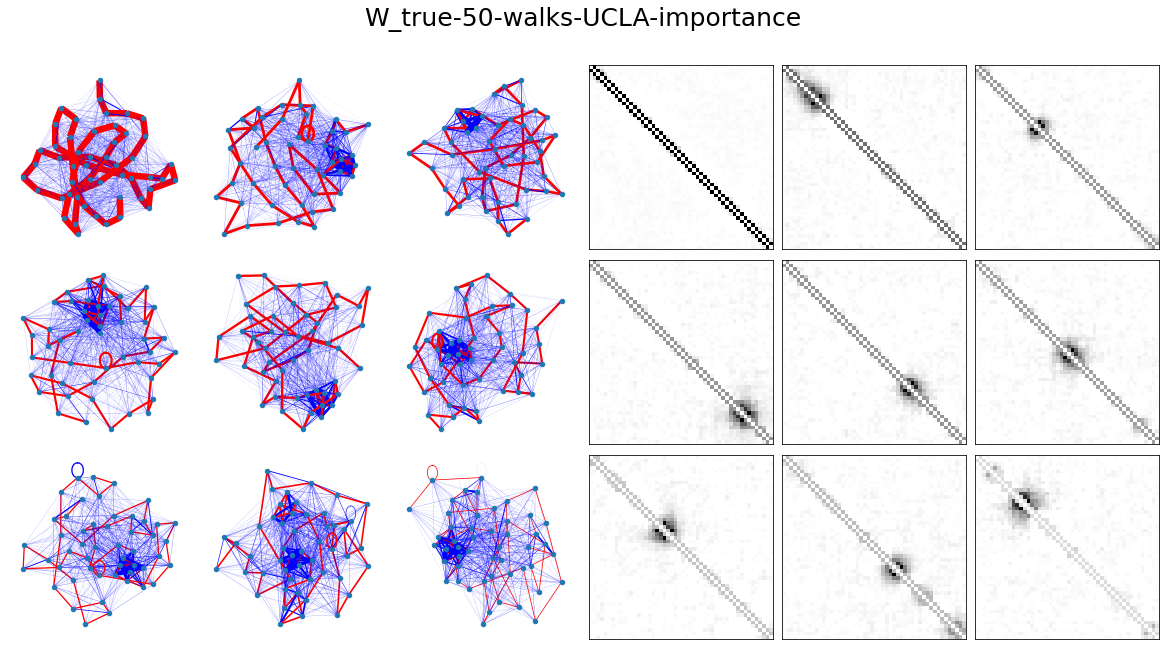

In [29]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_9Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

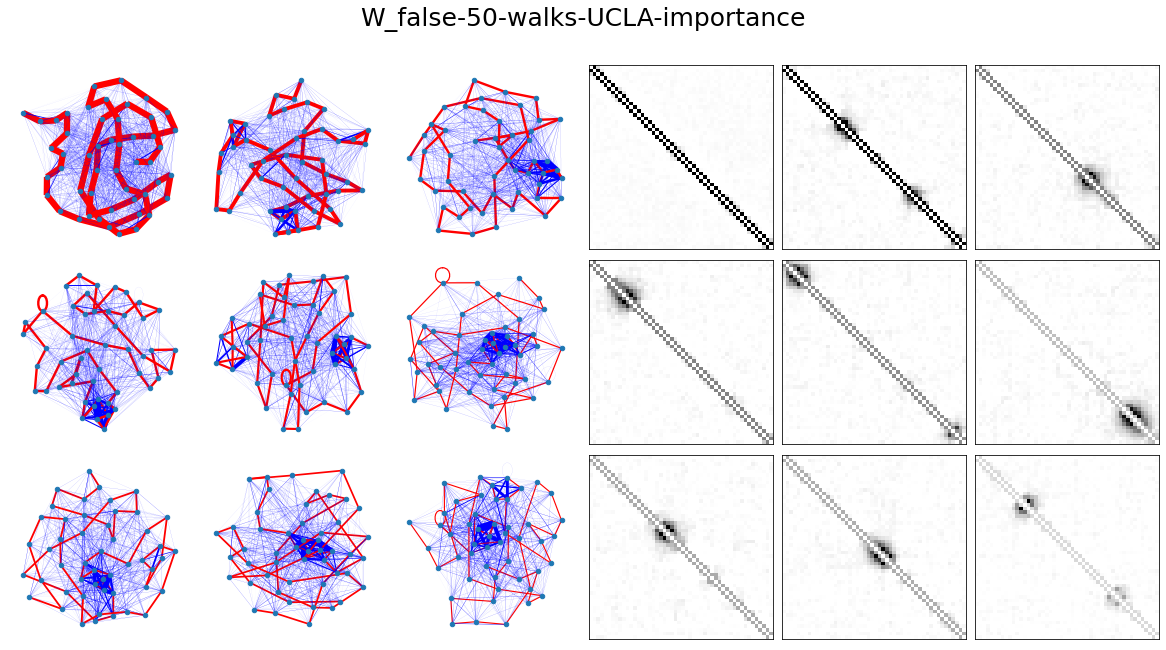

In [30]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_9Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

In [31]:
# SDL_BCD_feature
data_scale=10
results_dict_list9 = []
iteration1 = 200
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class9 = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                X_test = [X_test.T/data_scale, Y_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new9 = SDL_BCD_class9.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[-0.67953673 -0.61275172  0.2301311  -0.26379858 -0.34362563  0.59134522
   0.34841995 -0.31184904 -0.51239312  0.22637736]]


  1%|▍                                          | 2/200 [00:00<00:12, 16.22it/s]

--- Training --- [threshold, AUC] =  [1.537, 0.395]
--- Iteration 0: Training loss --- [Data, Label, Total] = [670.077506.3, 1307.747604.3, 1307.747604.3]


  5%|██                                        | 10/200 [00:00<00:08, 23.48it/s]


--- Training --- [threshold, AUC] =  [0.999, 0.565]
--- Iteration 10: Training loss --- [Data, Label, Total] = [926.669936.3, 6375.047268.3, 6375.047268.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.58448263  0.98165069  0.16826899 -0.50931029 -0.38998421  0.99890253
  -0.8669017   0.22556255 -0.63655272 -0.33988913]]


  4%|█▋                                         | 8/200 [00:00<00:05, 37.69it/s]

--- Training --- [threshold, AUC] =  [0.417, 0.6]
--- Iteration 0: Training loss --- [Data, Label, Total] = [722.186063.3, 1319.304605.3, 1319.304605.3]


  5%|██                                        | 10/200 [00:00<00:07, 25.95it/s]


--- Training --- [threshold, AUC] =  [0.0, 0.628]
--- Iteration 10: Training loss --- [Data, Label, Total] = [974.225162.3, 7318.441322.3, 7318.441322.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.82665878 -0.16342952  0.67042407 -0.79256946  0.45938776 -0.43556867
  -0.86973532  0.39716008  0.09910811 -0.27319323]]


  5%|██                                        | 10/200 [00:00<00:03, 47.53it/s]

--- Training --- [threshold, AUC] =  [0.45, 0.586]
--- Iteration 0: Training loss --- [Data, Label, Total] = [691.734766.3, 1305.209001.3, 1374.382478.3]


  5%|██                                        | 10/200 [00:00<00:06, 29.89it/s]


--- Training --- [threshold, AUC] =  [0.007, 0.628]
--- Iteration 10: Training loss --- [Data, Label, Total] = [856.434568.3, 4596.650632.3, 4682.294089.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.53337917 -0.62090274  0.73778026 -0.94209167 -0.42804448  0.54078009
   0.38291632 -0.07179585  0.3267343  -0.33798018]]


  2%|▋                                          | 3/200 [00:00<00:07, 26.88it/s]

--- Training --- [threshold, AUC] =  [0.511, 0.605]
--- Iteration 0: Training loss --- [Data, Label, Total] = [726.625142.3, 1300.964384.3, 1373.626898.3]


  5%|██                                        | 10/200 [00:00<00:07, 25.61it/s]


--- Training --- [threshold, AUC] =  [0.719, 0.627]
--- Iteration 10: Training loss --- [Data, Label, Total] = [897.572550.3, 1518.501141.3, 1608.258396.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.30500389  0.44072706 -0.34093743 -0.04903872  0.27569118  0.81015835
   0.84629007  0.18006824 -0.67389579  0.71495652]]


  2%|▋                                          | 3/200 [00:00<00:06, 28.53it/s]

--- Training --- [threshold, AUC] =  [0.477, 0.604]
--- Iteration 0: Training loss --- [Data, Label, Total] = [654.941943.3, 1299.828207.3, 1954.770150.3]


  5%|██                                        | 10/200 [00:00<00:07, 25.88it/s]


--- Training --- [threshold, AUC] =  [0.785, 0.624]
--- Iteration 10: Training loss --- [Data, Label, Total] = [511.123774.3, 1694.028943.3, 2205.152717.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.22159277 -0.44957118  0.36613788  0.27665589 -0.61975836  0.99088579
   0.72188284  0.52942153 -0.82438337  0.58379381]]


  3%|█▎                                         | 6/200 [00:00<00:09, 21.55it/s]

--- Training --- [threshold, AUC] =  [0.483, 0.603]
--- Iteration 0: Training loss --- [Data, Label, Total] = [673.221735.3, 1299.395454.3, 1972.617189.3]


  5%|██                                        | 10/200 [00:00<00:09, 21.09it/s]


--- Training --- [threshold, AUC] =  [0.031, 0.667]
--- Iteration 10: Training loss --- [Data, Label, Total] = [530.055281.3, 3208.931785.3, 3738.987066.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.27843335 -0.79194405  0.56434604  0.67280529  0.32224773  0.27263169
  -0.95996749 -0.91070815  0.98990446  0.06976762]]


  2%|█                                          | 5/200 [00:00<00:07, 24.91it/s]

--- Training --- [threshold, AUC] =  [1.531, 0.396]
--- Iteration 0: Training loss --- [Data, Label, Total] = [563.275255.3, 1305.825671.3, 4122.201948.3]


  8%|███▌                                      | 17/200 [00:00<00:04, 38.24it/s]

--- Training --- [threshold, AUC] =  [0.965, 0.623]
--- Iteration 10: Training loss --- [Data, Label, Total] = [256.148209.3, 3249.815525.3, 4530.556567.3]


 14%|█████▋                                    | 27/200 [00:00<00:04, 36.20it/s]

--- Training --- [threshold, AUC] =  [0.917, 0.435]
--- Iteration 20: Training loss --- [Data, Label, Total] = [127.702143.3, 2455.941642.3, 3094.452358.3]


 19%|███████▉                                  | 38/200 [00:01<00:04, 39.52it/s]

--- Training --- [threshold, AUC] =  [0.771, 0.442]
--- Iteration 30: Training loss --- [Data, Label, Total] = [109.961613.3, 1649.073472.3, 2198.881535.3]


 24%|██████████▎                               | 49/200 [00:01<00:03, 42.43it/s]

--- Training --- [threshold, AUC] =  [0.621, 0.546]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.909741.3, 1366.033997.3, 1370.582702.3]


 30%|████████████▌                             | 60/200 [00:01<00:03, 43.55it/s]

--- Training --- [threshold, AUC] =  [0.592, 0.726]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.488253.3, 1338.978591.3, 1341.419854.3]


 32%|█████████████▋                            | 65/200 [00:01<00:03, 41.26it/s]

--- Training --- [threshold, AUC] =  [0.568, 0.732]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.460757.3, 1322.507102.3, 1324.810885.3]


 38%|████████████████▏                         | 77/200 [00:02<00:02, 42.21it/s]

--- Training --- [threshold, AUC] =  [0.55, 0.728]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.454163.3, 1313.134793.3, 1315.405607.3]


 44%|██████████████████▍                       | 88/200 [00:02<00:02, 42.31it/s]

--- Training --- [threshold, AUC] =  [0.535, 0.725]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.446288.3, 1307.145433.3, 1309.376874.3]


 50%|████████████████████▌                    | 100/200 [00:02<00:02, 44.73it/s]

--- Training --- [threshold, AUC] =  [0.528, 0.722]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.438089.3, 1304.684026.3, 1306.874471.3]


 52%|█████████████████████▌                   | 105/200 [00:02<00:02, 41.51it/s]

--- Training --- [threshold, AUC] =  [0.52, 0.722]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.431919.3, 1302.823406.3, 1304.982999.3]


 58%|███████████████████████▉                 | 117/200 [00:02<00:01, 43.93it/s]

--- Training --- [threshold, AUC] =  [0.514, 0.723]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.428792.3, 1301.538465.3, 1303.682423.3]


 64%|██████████████████████████▏              | 128/200 [00:03<00:01, 44.73it/s]

--- Training --- [threshold, AUC] =  [0.51, 0.726]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.427489.3, 1300.779114.3, 1302.916559.3]


 69%|████████████████████████████▎            | 138/200 [00:03<00:01, 42.95it/s]

--- Training --- [threshold, AUC] =  [0.505, 0.727]
--- Iteration 130: Training loss --- [Data, Label, Total] = [nan.3, 1300.085983.3, nan.3]


 74%|██████████████████████████████▌          | 149/200 [00:03<00:01, 44.05it/s]

--- Training --- [threshold, AUC] =  [0.501, 0.728]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.426680.3, 1299.740019.3, 1301.873417.3]


 77%|███████████████████████████████▌         | 154/200 [00:03<00:01, 40.28it/s]

--- Training --- [threshold, AUC] =  [0.497, 0.728]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.426532.3, 1299.455585.3, 1301.588247.3]


 84%|██████████████████████████████████▏      | 167/200 [00:04<00:00, 44.44it/s]

--- Training --- [threshold, AUC] =  [0.494, 0.728]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.426451.3, 1299.319990.3, 1301.452243.3]


 89%|████████████████████████████████████▍    | 178/200 [00:04<00:00, 43.66it/s]

--- Training --- [threshold, AUC] =  [0.492, 0.729]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.426394.3, 1299.264544.3, 1301.396511.3]


 94%|██████████████████████████████████████▋  | 189/200 [00:04<00:00, 44.29it/s]

--- Training --- [threshold, AUC] =  [0.489, 0.729]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.426354.3, 1299.244689.3, 1301.376461.3]


100%|████████████████████████████████████████▊| 199/200 [00:05<00:00, 38.70it/s]

--- Training --- [threshold, AUC] =  [0.487, 0.729]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.426327.3, 1299.264925.3, 1301.396560.3]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 39.66it/s]


!!! pred_type naive
initial loading beta [[-0.63826728  0.77106864  0.23917892  0.41953279 -0.5807098  -0.20247374
   0.3205567  -0.65099737  0.85517875 -0.09898727]]


  2%|█                                          | 5/200 [00:00<00:08, 23.39it/s]

--- Training --- [threshold, AUC] =  [0.472, 0.604]
--- Iteration 0: Training loss --- [Data, Label, Total] = [564.365047.3, 1300.377887.3, 4122.203123.3]


  8%|███▎                                      | 16/200 [00:00<00:05, 31.80it/s]

--- Training --- [threshold, AUC] =  [0.285, 0.63]
--- Iteration 10: Training loss --- [Data, Label, Total] = [251.842819.3, 1472.713158.3, 2731.927251.3]


 12%|█████▎                                    | 25/200 [00:00<00:05, 33.44it/s]

--- Training --- [threshold, AUC] =  [0.508, 0.626]
--- Iteration 20: Training loss --- [Data, Label, Total] = [141.005756.3, 1300.374141.3, 2005.402922.3]


 15%|██████▎                                   | 30/200 [00:01<00:06, 26.55it/s]

--- Training --- [threshold, AUC] =  [0.774, 0.641]
--- Iteration 30: Training loss --- [Data, Label, Total] = [134.085821.3, 1659.410766.3, 2329.839873.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[ 0.22908402  0.56864003  0.38296752  0.95475014  0.61647366  0.70333508
   0.41326942 -0.96695909 -0.20802279 -0.02950533]]


  1%|▍                                          | 2/200 [00:00<00:32,  6.03it/s]

--- Training --- [threshold, AUC] =  [1.533, 0.394]
--- Iteration 0: Training loss --- [Data, Label, Total] = [535.403247.3, 1306.317536.3, 6660.350006.3]


  8%|███▎                                      | 16/200 [00:01<00:12, 15.24it/s]

--- Training --- [threshold, AUC] =  [0.69, 0.435]
--- Iteration 10: Training loss --- [Data, Label, Total] = [229.160586.3, 1461.591776.3, 3753.197638.3]


 14%|█████▋                                    | 27/200 [00:02<00:06, 28.19it/s]

--- Training --- [threshold, AUC] =  [0.697, 0.663]
--- Iteration 20: Training loss --- [Data, Label, Total] = [138.877608.3, 1474.215808.3, 2862.991884.3]


 18%|███████▊                                  | 37/200 [00:02<00:04, 37.01it/s]

--- Training --- [threshold, AUC] =  [0.901, 0.666]
--- Iteration 30: Training loss --- [Data, Label, Total] = [17.221937.3, 2305.790170.3, 2478.009539.3]


 20%|████████▍                                 | 40/200 [00:02<00:09, 16.27it/s]


--- Training --- [threshold, AUC] =  [0.942, 0.731]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.920974.3, 2772.074467.3, 2781.284203.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.66344867 -0.01022489 -0.80621052  0.17819066 -0.61626569 -0.5742944
   0.51138353 -0.5669703   0.42529892  0.06733908]]


  2%|▋                                          | 3/200 [00:00<00:06, 28.86it/s]

--- Training --- [threshold, AUC] =  [0.581, 0.604]
--- Iteration 0: Training loss --- [Data, Label, Total] = [565.754775.3, 1330.645575.3, 6988.193330.3]


 10%|████▏                                     | 20/200 [00:00<00:03, 45.50it/s]

--- Training --- [threshold, AUC] =  [0.992, 0.419]
--- Iteration 10: Training loss --- [Data, Label, Total] = [267.564678.3, 4658.049629.3, 7333.696405.3]


 12%|█████▎                                    | 25/200 [00:00<00:04, 40.44it/s]

--- Training --- [threshold, AUC] =  [0.897, 0.436]
--- Iteration 20: Training loss --- [Data, Label, Total] = [169.315773.3, 2277.162693.3, 3970.320425.3]


 18%|███████▊                                  | 37/200 [00:00<00:03, 43.84it/s]

--- Training --- [threshold, AUC] =  [0.656, 0.452]
--- Iteration 30: Training loss --- [Data, Label, Total] = [68.857649.3, 1408.213637.3, 2096.790127.3]


 24%|██████████                                | 48/200 [00:01<00:03, 44.27it/s]

--- Training --- [threshold, AUC] =  [0.591, 0.583]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.648164.3, 1338.383822.3, 1354.865465.3]


 30%|████████████▌                             | 60/200 [00:01<00:03, 45.88it/s]

--- Training --- [threshold, AUC] =  [0.581, 0.728]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.567421.3, 1330.831191.3, 1336.505404.3]


 32%|█████████████▋                            | 65/200 [00:01<00:03, 41.87it/s]

--- Training --- [threshold, AUC] =  [0.573, 0.726]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.450066.3, 1325.763916.3, 1330.264580.3]


 38%|███████████████▉                          | 76/200 [00:01<00:03, 40.74it/s]

--- Training --- [threshold, AUC] =  [0.563, 0.723]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.436209.3, 1319.482636.3, 1323.844723.3]


 43%|██████████████████                        | 86/200 [00:02<00:02, 39.21it/s]

--- Training --- [threshold, AUC] =  [0.555, 0.724]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.429881.3, 1315.592390.3, 1319.891201.3]


 48%|████████████████████▎                     | 97/200 [00:02<00:02, 41.30it/s]

--- Training --- [threshold, AUC] =  [0.551, 0.725]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.427730.3, 1313.365158.3, 1317.642462.3]


 54%|██████████████████████▏                  | 108/200 [00:02<00:02, 43.61it/s]

--- Training --- [threshold, AUC] =  [0.547, 0.727]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.426863.3, 1311.575951.3, 1315.844584.3]


 60%|████████████████████████▍                | 119/200 [00:02<00:01, 43.90it/s]

--- Training --- [threshold, AUC] =  [0.544, 0.727]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.426534.3, 1310.449945.3, 1314.715282.3]


 64%|██████████████████████████▍              | 129/200 [00:03<00:01, 43.49it/s]

--- Training --- [threshold, AUC] =  [0.541, 0.727]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.426321.3, 1309.104624.3, 1313.367838.3]


 70%|████████████████████████████▋            | 140/200 [00:03<00:01, 44.63it/s]

--- Training --- [threshold, AUC] =  [0.538, 0.727]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.426225.3, 1307.944113.3, 1312.206363.3]


 72%|█████████████████████████████▋           | 145/200 [00:03<00:01, 40.34it/s]

--- Training --- [threshold, AUC] =  [0.535, 0.728]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.426162.3, 1306.913677.3, 1311.175300.3]


 78%|███████████████████████████████▉         | 156/200 [00:03<00:01, 39.80it/s]

--- Training --- [threshold, AUC] =  [0.532, 0.728]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.426124.3, 1306.130454.3, 1310.391698.3]


 84%|██████████████████████████████████▍      | 168/200 [00:04<00:00, 44.90it/s]

--- Training --- [threshold, AUC] =  [0.531, 0.728]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.426102.3, 1305.650005.3, 1309.911023.3]


 90%|████████████████████████████████████▋    | 179/200 [00:04<00:00, 46.43it/s]

--- Training --- [threshold, AUC] =  [0.529, 0.728]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.426085.3, 1305.043439.3, 1309.304290.3]


 95%|██████████████████████████████████████▉  | 190/200 [00:04<00:00, 45.90it/s]

--- Training --- [threshold, AUC] =  [0.527, 0.729]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.426069.3, 1304.617327.3, 1308.878017.3]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 41.70it/s]

--- Training --- [threshold, AUC] =  [0.526, 0.729]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.426057.3, 1304.107998.3, 1308.368569.3]
!!! pred_type naive


In [32]:
W = results_dict_new9['loading'][0]
coeff = results_dict_new9['loading'][1][0]
H = results_dict_new9['code']

In [33]:
coeff

array([-0.04266605,  0.00172059,  0.05279475,  0.0013875 ,  0.00069734,
        0.00023889,  0.00021065,  0.00035225,  0.00068121,  0.00115448])

In [34]:
print('Accuracy: {}'.format(results_dict_new9['Accuracy']))
print('Training RRE: {}'.format(results_dict_new9['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new9['Relative_reconstruction_loss (test)']))

Accuracy: 0.5856
Training RRE: 0.35736806723414305
Testing RRE: 0.6076361781117934


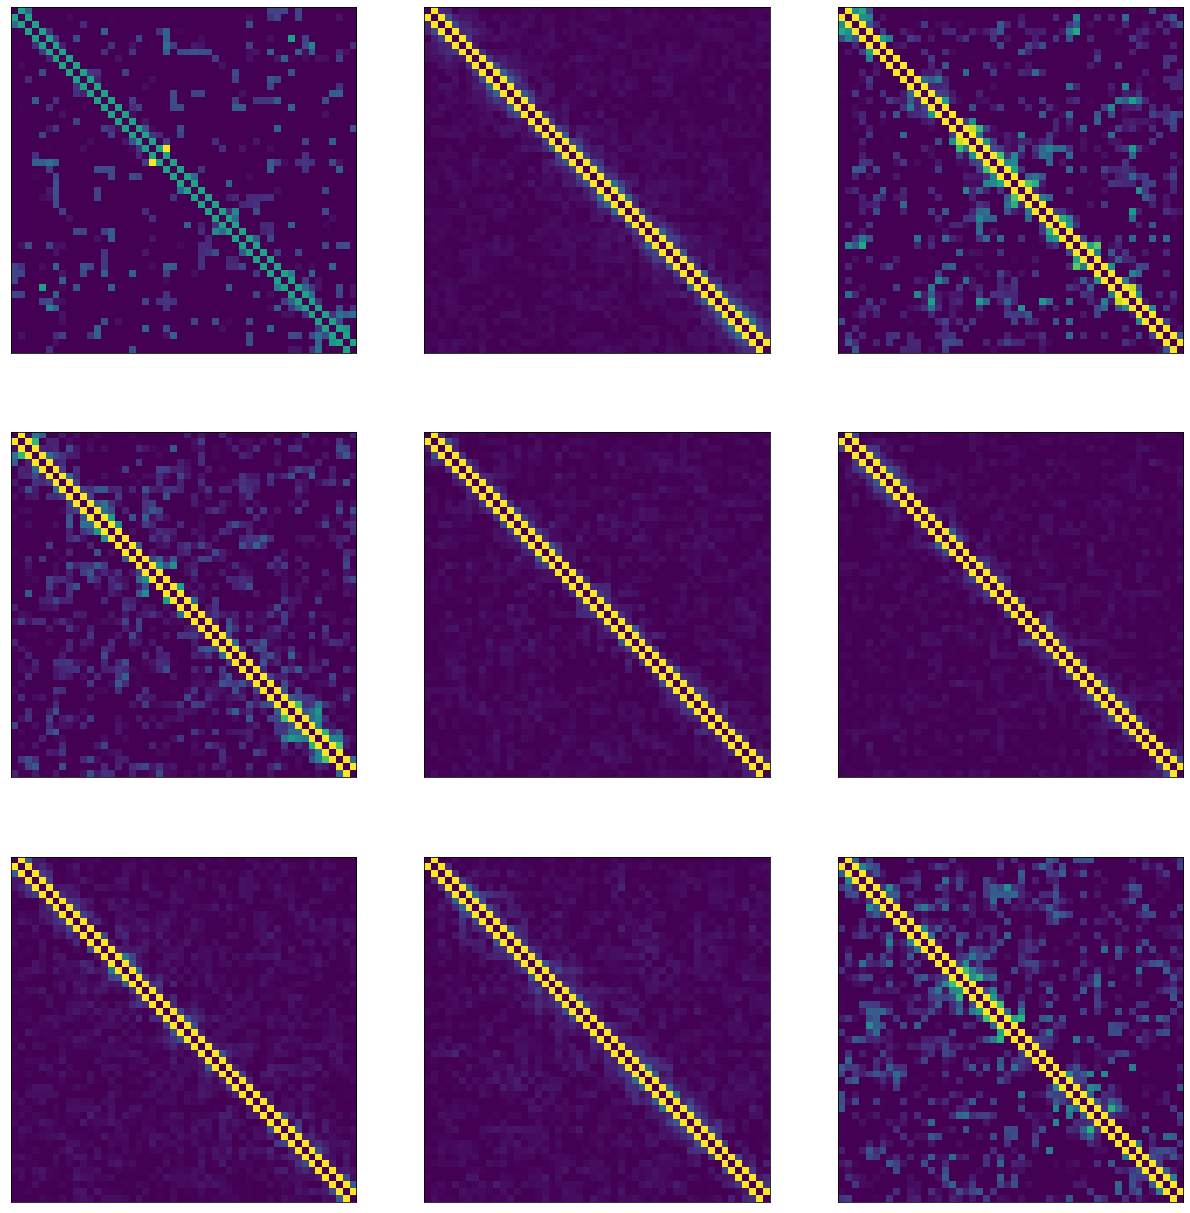

In [35]:
display_dictionary(W = W, figsize=[20,20])

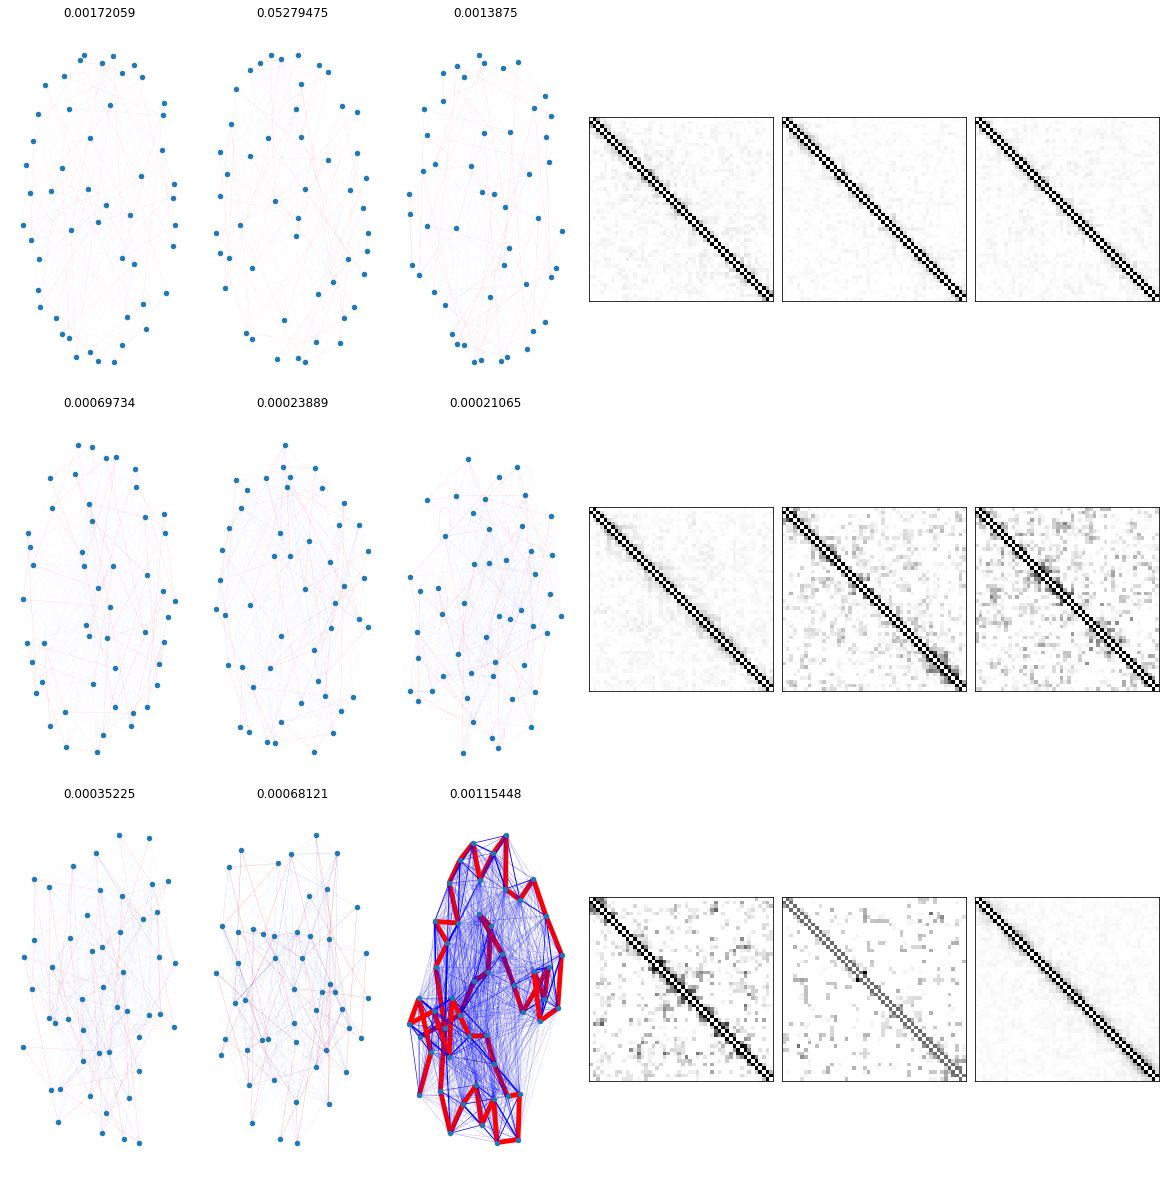

In [36]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 50, 
                       fig_size = [20,20], 
                       show_importance = False)

In [37]:
# SDL_BCD_filter
data_scale=10
results_dict_list_filter9 = []
iteration1 = 200
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class_filter9 = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                       X_test = [X_test.T/data_scale, Y_test.T],
                                       n_components = r,
                                       xi = xi,
                                       L1_reg = [0,0,0],
                                       L2_reg = [0,0,0],
                                       nonnegativity = [True,True,False],
                                       full_dim = False)

        results_dict_new_filter9 = SDL_BCD_class_filter9.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.71071121  0.64923162  0.39001964  0.02278353  0.24685675  0.74641998
  -0.43700422 -0.15216672 -0.54914536  0.68089879]]


  1%|▍                                          | 2/200 [00:00<00:33,  5.93it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 0: Training loss --- [Data, Label, Total] = [339.157069.3, 1299.218430.3, 1299.218430.3]


  6%|██▌                                       | 12/200 [00:01<00:28,  6.58it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.64]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.375517.3, 1299.213179.3, 1299.213179.3]


 10%|████▍                                     | 21/200 [00:03<00:37,  4.72it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.692]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.146053.3, 1299.150983.3, 1299.150983.3]


 16%|██████▋                                   | 32/200 [00:05<00:25,  6.62it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.167503.3, 1299.099719.3, 1299.099719.3]


 21%|████████▊                                 | 42/200 [00:06<00:23,  6.73it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.174290.3, 1299.095971.3, 1299.095971.3]


 26%|██████████▉                               | 52/200 [00:07<00:21,  6.96it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.175457.3, 1299.095846.3, 1299.095846.3]


 31%|█████████████                             | 62/200 [00:09<00:21,  6.39it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.175484.3, 1299.095842.3, 1299.095842.3]


 36%|███████████████                           | 72/200 [00:10<00:19,  6.44it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 41%|█████████████████▏                        | 82/200 [00:12<00:17,  6.69it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 46%|███████████████████▎                      | 92/200 [00:13<00:16,  6.63it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 51%|████████████████████▉                    | 102/200 [00:15<00:14,  6.97it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 56%|██████████████████████▉                  | 112/200 [00:16<00:12,  6.94it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 61%|█████████████████████████                | 122/200 [00:17<00:11,  6.69it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 66%|███████████████████████████              | 132/200 [00:19<00:09,  6.91it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 71%|█████████████████████████████            | 142/200 [00:20<00:08,  6.45it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 76%|███████████████████████████████▏         | 152/200 [00:22<00:07,  6.11it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 81%|█████████████████████████████████▏       | 162/200 [00:23<00:05,  6.66it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 86%|███████████████████████████████████▎     | 172/200 [00:25<00:04,  6.15it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:27<00:02,  6.03it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:28<00:01,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.63it/s]


!!! pred_type filter
initial loading beta [[-0.46558688 -0.90359888  0.3760883   0.11877826 -0.67047758  0.30915776
  -0.42782136 -0.13315163 -0.79799497  0.84831191]]


  1%|▍                                          | 2/200 [00:00<00:36,  5.42it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.632]
--- Iteration 0: Training loss --- [Data, Label, Total] = [341.628106.3, 1299.217968.3, 1299.217968.3]


  6%|██▌                                       | 12/200 [00:02<00:33,  5.54it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.64]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.386330.3, 1299.212707.3, 1299.212707.3]


 11%|████▌                                     | 22/200 [00:03<00:30,  5.76it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.692]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.148887.3, 1299.150011.3, 1299.150011.3]


 16%|██████▋                                   | 32/200 [00:05<00:26,  6.37it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.168316.3, 1299.099481.3, 1299.099481.3]


 21%|████████▊                                 | 42/200 [00:06<00:25,  6.09it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.174439.3, 1299.095960.3, 1299.095960.3]


 26%|██████████▉                               | 52/200 [00:08<00:22,  6.60it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.175468.3, 1299.095846.3, 1299.095846.3]


 31%|█████████████                             | 62/200 [00:10<00:24,  5.64it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.175485.3, 1299.095842.3, 1299.095842.3]


 36%|███████████████                           | 72/200 [00:12<00:21,  5.82it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.175486.3, 1299.095842.3, 1299.095842.3]


 41%|█████████████████▏                        | 82/200 [00:13<00:18,  6.22it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 46%|███████████████████▎                      | 92/200 [00:15<00:18,  5.92it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 51%|████████████████████▉                    | 102/200 [00:16<00:15,  6.35it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 56%|██████████████████████▉                  | 112/200 [00:18<00:13,  6.38it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 61%|█████████████████████████                | 122/200 [00:20<00:15,  4.97it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 66%|███████████████████████████              | 132/200 [00:23<00:18,  3.72it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 70%|████████████████████████████▉            | 141/200 [00:24<00:11,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 76%|███████████████████████████████▏         | 152/200 [00:27<00:07,  6.19it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 81%|█████████████████████████████████▏       | 162/200 [00:28<00:05,  7.12it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 86%|███████████████████████████████████▎     | 172/200 [00:29<00:04,  6.32it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:31<00:02,  6.13it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:33<00:01,  5.93it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.175487.3, 1299.095842.3, 1299.095842.3]


100%|█████████████████████████████████████████| 200/200 [00:35<00:00,  5.56it/s]


!!! pred_type filter
initial loading beta [[-3.86176057e-01 -4.31459898e-01  9.97958478e-01  8.58435888e-01
   5.10741877e-04 -8.96120151e-02  5.96863553e-01  5.95534017e-01
   9.35076781e-01 -7.94830954e-01]]


  0%|▏                                          | 1/200 [00:00<00:38,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.63]
--- Iteration 0: Training loss --- [Data, Label, Total] = [353.587887.3, 1299.220176.3, 1334.578965.3]


  6%|██▌                                       | 12/200 [00:01<00:28,  6.68it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.636]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.344566.3, 1299.218291.3, 1299.352748.3]


 11%|████▌                                     | 22/200 [00:03<00:27,  6.40it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.662]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.739562.3, 1299.200270.3, 1299.274226.3]


 16%|██████▋                                   | 32/200 [00:04<00:27,  6.12it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.682]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.493017.3, 1299.178644.3, 1299.227945.3]


 20%|████████▌                                 | 41/200 [00:06<00:27,  5.68it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.693]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.447330.3, 1299.158529.3, 1299.203262.3]


 26%|██████████▋                               | 51/200 [00:07<00:25,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.7]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.437711.3, 1299.142234.3, 1299.186005.3]


 31%|█████████████                             | 62/200 [00:09<00:22,  6.09it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.703]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.434440.3, 1299.130491.3, 1299.173935.3]


 36%|███████████████                           | 72/200 [00:10<00:20,  6.14it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.705]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.432739.3, 1299.122352.3, 1299.165625.3]


 41%|█████████████████▏                        | 82/200 [00:12<00:18,  6.51it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.706]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.431598.3, 1299.116703.3, 1299.159862.3]


 46%|███████████████████▎                      | 92/200 [00:13<00:17,  6.02it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.430738.3, 1299.112722.3, 1299.155796.3]


 51%|████████████████████▉                    | 102/200 [00:15<00:14,  6.61it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.430053.3, 1299.109850.3, 1299.152855.3]


 56%|██████████████████████▉                  | 112/200 [00:17<00:15,  5.60it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.429490.3, 1299.107718.3, 1299.150667.3]


 61%|█████████████████████████                | 122/200 [00:18<00:13,  5.74it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.429020.3, 1299.106097.3, 1299.148999.3]


 66%|███████████████████████████              | 132/200 [00:20<00:10,  6.52it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.428621.3, 1299.104838.3, 1299.147700.3]


 71%|█████████████████████████████            | 142/200 [00:21<00:08,  6.78it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.428279.3, 1299.103841.3, 1299.146669.3]


 76%|███████████████████████████████▏         | 152/200 [00:23<00:07,  6.00it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.427984.3, 1299.103040.3, 1299.145839.3]


 81%|█████████████████████████████████▏       | 162/200 [00:24<00:05,  6.40it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.427727.3, 1299.102388.3, 1299.145160.3]


 86%|███████████████████████████████████▎     | 172/200 [00:26<00:04,  6.63it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.427501.3, 1299.101848.3, 1299.144598.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:27<00:02,  6.18it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.427300.3, 1299.101396.3, 1299.144126.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:29<00:01,  6.47it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.427122.3, 1299.101014.3, 1299.143726.3]


100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.57it/s]


!!! pred_type filter
initial loading beta [[ 0.28572864  0.08684057  0.49355496  0.32908598  0.93275401 -0.6022603
   0.20126535  0.32413496 -0.39008842 -0.13121463]]


  1%|▍                                          | 2/200 [00:00<00:33,  5.99it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.632]
--- Iteration 0: Training loss --- [Data, Label, Total] = [352.803787.3, 1299.219362.3, 1334.499741.3]


  6%|██▌                                       | 12/200 [00:01<00:29,  6.33it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.639]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.340992.3, 1299.217630.3, 1299.351729.3]


 11%|████▌                                     | 22/200 [00:03<00:28,  6.33it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.661]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.719955.3, 1299.202404.3, 1299.274399.3]


 16%|██████▋                                   | 32/200 [00:04<00:26,  6.37it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.678]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.481605.3, 1299.184464.3, 1299.232624.3]


 21%|████████▊                                 | 42/200 [00:06<00:24,  6.44it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.689]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.442914.3, 1299.167083.3, 1299.211375.3]


 26%|██████████▉                               | 52/200 [00:07<00:22,  6.72it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.696]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.435096.3, 1299.151724.3, 1299.195234.3]


 31%|█████████████                             | 62/200 [00:09<00:21,  6.48it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.701]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.432626.3, 1299.139363.3, 1299.182625.3]


 36%|███████████████                           | 72/200 [00:10<00:19,  6.52it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.703]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.431509.3, 1299.129974.3, 1299.173125.3]


 41%|█████████████████▏                        | 82/200 [00:12<00:19,  6.02it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.705]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.430817.3, 1299.123005.3, 1299.166087.3]


 46%|███████████████████▎                      | 92/200 [00:14<00:25,  4.24it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.706]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.430287.3, 1299.117829.3, 1299.160858.3]


 51%|████████████████████▉                    | 102/200 [00:16<00:14,  6.91it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.429836.3, 1299.113967.3, 1299.156951.3]


 56%|██████████████████████▉                  | 112/200 [00:17<00:13,  6.62it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.429437.3, 1299.111050.3, 1299.153994.3]


 61%|█████████████████████████                | 122/200 [00:18<00:11,  7.06it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.429080.3, 1299.108811.3, 1299.151719.3]


 66%|███████████████████████████              | 132/200 [00:20<00:09,  6.94it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.707]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.428757.3, 1299.107067.3, 1299.149943.3]


 71%|█████████████████████████████            | 142/200 [00:21<00:08,  7.12it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.428466.3, 1299.105688.3, 1299.148534.3]


 76%|███████████████████████████████▏         | 152/200 [00:22<00:07,  6.65it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.428204.3, 1299.104584.3, 1299.147404.3]


 81%|█████████████████████████████████▏       | 162/200 [00:24<00:06,  5.72it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.427969.3, 1299.103686.3, 1299.146483.3]


 86%|███████████████████████████████████▎     | 172/200 [00:26<00:05,  5.31it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.427757.3, 1299.102947.3, 1299.145723.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:28<00:03,  5.82it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.427567.3, 1299.102334.3, 1299.145091.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:29<00:01,  6.80it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.708]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.427396.3, 1299.101821.3, 1299.144561.3]


100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.53it/s]


!!! pred_type filter
initial loading beta [[-0.19448398 -0.18508198  0.84884047 -0.68733068 -0.97094507  0.3494349
   0.68017155  0.77751033 -0.99135292 -0.91222725]]


  1%|▍                                          | 2/200 [00:00<00:35,  5.63it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.632]
--- Iteration 0: Training loss --- [Data, Label, Total] = [453.650266.3, 1299.227675.3, 1752.877941.3]


  6%|██▌                                       | 12/200 [00:01<00:28,  6.61it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.622]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.138715.3, 1299.233724.3, 1300.372439.3]


 11%|████▌                                     | 22/200 [00:03<00:25,  7.06it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.623]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.533188.3, 1299.233066.3, 1299.766254.3]


 16%|██████▋                                   | 32/200 [00:04<00:24,  6.74it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.624]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.463530.3, 1299.232539.3, 1299.696070.3]


 21%|████████▊                                 | 42/200 [00:06<00:23,  6.85it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.626]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.444013.3, 1299.232003.3, 1299.676016.3]


 26%|██████████▉                               | 52/200 [00:07<00:22,  6.51it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.628]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.436082.3, 1299.231440.3, 1299.667523.3]


 31%|█████████████                             | 62/200 [00:08<00:19,  7.15it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.629]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.432157.3, 1299.230851.3, 1299.663009.3]


 36%|███████████████                           | 72/200 [00:10<00:18,  6.85it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.631]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.429964.3, 1299.230236.3, 1299.660200.3]


 41%|█████████████████▏                        | 82/200 [00:11<00:18,  6.53it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.633]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.428631.3, 1299.229594.3, 1299.658225.3]


 46%|███████████████████                       | 91/200 [00:13<00:23,  4.60it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.635]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.427766.3, 1299.228926.3, 1299.656692.3]


 51%|████████████████████▉                    | 102/200 [00:16<00:19,  4.92it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.636]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.427173.3, 1299.228231.3, 1299.655404.3]


 56%|██████████████████████▉                  | 112/200 [00:18<00:15,  5.65it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.638]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.426746.3, 1299.227509.3, 1299.654255.3]


 60%|████████████████████████▊                | 121/200 [00:19<00:15,  5.26it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.639]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.426425.3, 1299.226760.3, 1299.653185.3]


 66%|███████████████████████████              | 132/200 [00:21<00:13,  4.91it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.641]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.426175.3, 1299.225983.3, 1299.652157.3]


 71%|█████████████████████████████            | 142/200 [00:23<00:12,  4.76it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.643]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.425972.3, 1299.225178.3, 1299.651149.3]


 76%|███████████████████████████████▏         | 152/200 [00:25<00:07,  6.01it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.644]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.425802.3, 1299.224343.3, 1299.650145.3]


 81%|█████████████████████████████████▏       | 162/200 [00:26<00:05,  6.38it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.646]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.425656.3, 1299.223480.3, 1299.649136.3]


 86%|███████████████████████████████████▎     | 172/200 [00:28<00:04,  6.16it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.648]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.425527.3, 1299.222619.3, 1299.648146.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:29<00:02,  6.28it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.649]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.425410.3, 1299.221700.3, 1299.647110.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:32<00:02,  3.46it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.651]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.425301.3, 1299.220752.3, 1299.646053.3]


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.98it/s]


!!! pred_type filter
initial loading beta [[ 0.21281132  0.25113151  0.04398971 -0.39829418 -0.92811498  0.46264496
   0.05501811 -0.23069494 -0.63697643 -0.26541334]]


  0%|▏                                          | 1/200 [00:00<00:38,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.632]
--- Iteration 0: Training loss --- [Data, Label, Total] = [459.803265.3, 1299.228093.3, 1759.031358.3]


  6%|██▌                                       | 12/200 [00:01<00:28,  6.54it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.625]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.809547.3, 1299.234467.3, 1300.044014.3]


 11%|████▌                                     | 22/200 [00:03<00:25,  6.97it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.627]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.509383.3, 1299.233824.3, 1299.743207.3]


 16%|██████▋                                   | 32/200 [00:04<00:23,  7.09it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.629]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.470320.3, 1299.233254.3, 1299.703574.3]


 21%|████████▊                                 | 42/200 [00:05<00:21,  7.31it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.63]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.453890.3, 1299.232718.3, 1299.686608.3]


 26%|██████████▉                               | 52/200 [00:07<00:23,  6.40it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.632]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.444924.3, 1299.232123.3, 1299.677048.3]


 30%|████████████▊                             | 61/200 [00:09<00:33,  4.18it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.634]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.439436.3, 1299.231500.3, 1299.670936.3]


 36%|███████████████                           | 72/200 [00:11<00:21,  6.02it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.636]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.435839.3, 1299.230846.3, 1299.666686.3]


 41%|█████████████████▏                        | 82/200 [00:13<00:23,  5.11it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.638]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.433371.3, 1299.230163.3, 1299.663534.3]


 46%|███████████████████▎                      | 92/200 [00:15<00:16,  6.48it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.639]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.431614.3, 1299.229448.3, 1299.661062.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:15,  6.22it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.641]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.430328.3, 1299.228701.3, 1299.659030.3]


 56%|██████████████████████▉                  | 112/200 [00:18<00:15,  5.50it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.643]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.429362.3, 1299.227922.3, 1299.657284.3]


 61%|█████████████████████████                | 122/200 [00:21<00:14,  5.51it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.644]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.428621.3, 1299.227109.3, 1299.655730.3]


 66%|███████████████████████████              | 132/200 [00:22<00:11,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.646]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.428040.3, 1299.226261.3, 1299.654302.3]


 70%|████████████████████████████▉            | 141/200 [00:24<00:08,  6.74it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.648]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.427577.3, 1299.225379.3, 1299.652956.3]


 76%|███████████████████████████████▏         | 152/200 [00:25<00:06,  7.07it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.649]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.427201.3, 1299.224461.3, 1299.651661.3]


 81%|█████████████████████████████████▏       | 162/200 [00:27<00:06,  6.25it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.651]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.426889.3, 1299.223507.3, 1299.650396.3]


 86%|███████████████████████████████████▎     | 172/200 [00:28<00:04,  6.60it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.653]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.426627.3, 1299.222550.3, 1299.649177.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:29<00:02,  7.02it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.654]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.426403.3, 1299.221529.3, 1299.647932.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:31<00:01,  6.29it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.656]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.426209.3, 1299.220470.3, 1299.646680.3]


100%|█████████████████████████████████████████| 200/200 [00:32<00:00,  6.10it/s]


!!! pred_type filter
initial loading beta [[-0.64094933 -0.51764706  0.59854851  0.39328561  0.45746365 -0.6551903
   0.60908883  0.23248384  0.67557748 -0.58639266]]


  1%|▍                                          | 2/200 [00:00<00:28,  7.03it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.636]
--- Iteration 0: Training loss --- [Data, Label, Total] = [445.778815.3, 1299.240464.3, 3528.134537.3]


  6%|██▌                                       | 12/200 [00:01<00:26,  7.05it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.596]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.689576.3, 1299.242588.3, 1302.690466.3]


 11%|████▌                                     | 22/200 [00:02<00:26,  6.81it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.596]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.461080.3, 1299.242573.3, 1301.547972.3]


 16%|██████▋                                   | 32/200 [00:04<00:25,  6.67it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.596]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.453532.3, 1299.242556.3, 1301.510218.3]


 21%|████████▊                                 | 42/200 [00:05<00:23,  6.80it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.596]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.451390.3, 1299.242541.3, 1301.499490.3]


 26%|██████████▉                               | 52/200 [00:07<00:22,  6.64it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.449888.3, 1299.242525.3, 1301.491964.3]


 31%|█████████████                             | 62/200 [00:08<00:19,  7.20it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.448525.3, 1299.242509.3, 1301.485134.3]


 36%|███████████████                           | 72/200 [00:09<00:18,  6.77it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.447227.3, 1299.242494.3, 1301.478628.3]


 41%|█████████████████▏                        | 82/200 [00:11<00:17,  6.83it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.445982.3, 1299.242488.3, 1301.472398.3]


 46%|███████████████████▎                      | 92/200 [00:12<00:17,  6.16it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.597]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.444788.3, 1299.242473.3, 1301.466414.3]


 51%|████████████████████▉                    | 102/200 [00:14<00:15,  6.30it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.443645.3, 1299.242459.3, 1301.460682.3]


 56%|██████████████████████▉                  | 112/200 [00:15<00:13,  6.44it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.442551.3, 1299.242444.3, 1301.455200.3]


 61%|█████████████████████████                | 122/200 [00:17<00:11,  6.92it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.441508.3, 1299.242429.3, 1301.449970.3]


 66%|███████████████████████████              | 132/200 [00:18<00:09,  7.51it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.440515.3, 1299.242415.3, 1301.444987.3]


 71%|█████████████████████████████            | 142/200 [00:19<00:07,  7.66it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.439570.3, 1299.242400.3, 1301.440252.3]


 76%|███████████████████████████████▏         | 152/200 [00:21<00:06,  7.44it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.598]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.438675.3, 1299.242385.3, 1301.435761.3]


 81%|█████████████████████████████████▏       | 162/200 [00:22<00:04,  7.66it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.599]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.437827.3, 1299.242371.3, 1301.431506.3]


 86%|███████████████████████████████████▎     | 172/200 [00:23<00:03,  7.33it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.599]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.437025.3, 1299.242356.3, 1301.427483.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:24<00:02,  7.49it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.599]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.436269.3, 1299.242341.3, 1301.423686.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:26<00:01,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.599]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.435556.3, 1299.242327.3, 1301.420107.3]


100%|█████████████████████████████████████████| 200/200 [00:27<00:00,  7.26it/s]


!!! pred_type filter
initial loading beta [[-0.96099328  0.74412484  0.81563987  0.76287965  0.16319522  0.60556917
  -0.0821817   0.94943596 -0.96515055 -0.95671354]]


  1%|▍                                          | 2/200 [00:00<00:37,  5.28it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.632]
--- Iteration 0: Training loss --- [Data, Label, Total] = [448.025462.3, 1299.240565.3, 3539.367873.3]


  6%|██▌                                       | 12/200 [00:01<00:28,  6.57it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.605]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.776342.3, 1299.242190.3, 1303.123902.3]


 11%|████▌                                     | 22/200 [00:03<00:24,  7.21it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.604]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.495299.3, 1299.242218.3, 1301.718712.3]


 16%|██████▋                                   | 32/200 [00:04<00:22,  7.59it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.603]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.464530.3, 1299.242212.3, 1301.564860.3]


 21%|████████▊                                 | 42/200 [00:05<00:20,  7.80it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.604]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.456070.3, 1299.242199.3, 1301.522550.3]


 26%|██████████▋                               | 51/200 [00:07<00:32,  4.53it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.604]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.451590.3, 1299.242185.3, 1301.500136.3]


 31%|█████████████                             | 62/200 [00:11<00:39,  3.50it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.604]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.448021.3, 1299.242171.3, 1301.482278.3]


 36%|███████████████                           | 72/200 [00:12<00:19,  6.62it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.604]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.444765.3, 1299.242157.3, 1301.465980.3]


 40%|█████████████████                         | 81/200 [00:14<00:21,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.604]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.441734.3, 1299.242143.3, 1301.450812.3]


 46%|███████████████████▎                      | 92/200 [00:15<00:15,  6.94it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.604]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.438958.3, 1299.242129.3, 1301.436918.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:16,  6.02it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.604]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.436479.3, 1299.242116.3, 1301.424513.3]


 56%|██████████████████████▊                  | 111/200 [00:18<00:15,  5.65it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.605]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.434337.3, 1299.242102.3, 1301.413788.3]


 61%|█████████████████████████                | 122/200 [00:20<00:13,  5.73it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.605]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.432544.3, 1299.242089.3, 1301.404808.3]


 66%|███████████████████████████              | 132/200 [00:22<00:11,  6.07it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.605]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.431086.3, 1299.242076.3, 1301.397506.3]


 71%|█████████████████████████████            | 142/200 [00:23<00:07,  7.39it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.605]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.429931.3, 1299.242062.3, 1301.391716.3]


 76%|███████████████████████████████▏         | 152/200 [00:25<00:06,  6.88it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.605]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.429033.3, 1299.242049.3, 1301.387213.3]


 81%|█████████████████████████████████▏       | 162/200 [00:26<00:06,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.605]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.428346.3, 1299.242035.3, 1301.383765.3]


 86%|███████████████████████████████████▎     | 172/200 [00:28<00:04,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.606]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.427825.3, 1299.242021.3, 1301.381148.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:29<00:02,  6.40it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.606]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.427434.3, 1299.242007.3, 1301.379177.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:31<00:01,  6.91it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.606]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.427141.3, 1299.241994.3, 1301.377698.3]


100%|█████████████████████████████████████████| 200/200 [00:32<00:00,  6.21it/s]


!!! pred_type filter
initial loading beta [[ 0.60646712 -0.84985397 -0.31477391  0.73983767  0.57370394 -0.96937016
  -0.25655172  0.23944427 -0.41390067  0.85053608]]


  1%|▍                                          | 2/200 [00:00<00:33,  5.87it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.564]
--- Iteration 0: Training loss --- [Data, Label, Total] = [362.917471.3, 1299.245224.3, 4928.419933.3]


  6%|██▌                                       | 12/200 [00:01<00:28,  6.59it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.555]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.280260.3, 1299.245334.3, 1312.047930.3]


 11%|████▌                                     | 22/200 [00:03<00:26,  6.61it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.562]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.185814.3, 1299.245334.3, 1311.103474.3]


 16%|██████▋                                   | 32/200 [00:04<00:30,  5.56it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.563]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.185489.3, 1299.245334.3, 1311.100227.3]


 21%|████████▊                                 | 42/200 [00:06<00:22,  7.06it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.563]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.186795.3, 1299.245334.3, 1311.113283.3]


 26%|██████████▉                               | 52/200 [00:07<00:20,  7.09it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.564]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.188064.3, 1299.245334.3, 1311.125973.3]


 31%|█████████████                             | 62/200 [00:08<00:19,  6.97it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.565]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.188126.3, 1299.245334.3, 1311.126590.3]


 36%|███████████████                           | 72/200 [00:10<00:19,  6.72it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.566]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.185265.3, 1299.245334.3, 1311.097982.3]


 41%|█████████████████▏                        | 82/200 [00:11<00:17,  6.82it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.567]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.182236.3, 1299.245334.3, 1311.067699.3]


 46%|███████████████████                       | 91/200 [00:13<00:18,  5.96it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.568]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.177614.3, 1299.245334.3, 1311.021469.3]


 51%|████████████████████▉                    | 102/200 [00:15<00:17,  5.47it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.569]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.172405.3, 1299.245334.3, 1310.969381.3]


 56%|██████████████████████▉                  | 112/200 [00:17<00:15,  5.52it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.57]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.167206.3, 1299.245334.3, 1310.917390.3]


 61%|█████████████████████████                | 122/200 [00:18<00:12,  6.33it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.572]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.161997.3, 1299.245334.3, 1310.865299.3]


 66%|███████████████████████████              | 132/200 [00:20<00:11,  6.17it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.573]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.156761.3, 1299.245334.3, 1310.812949.3]


 71%|█████████████████████████████            | 142/200 [00:21<00:08,  6.65it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.574]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.151496.3, 1299.245334.3, 1310.760294.3]


 76%|███████████████████████████████▏         | 152/200 [00:23<00:07,  6.27it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.575]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.146165.3, 1299.245334.3, 1310.706979.3]


 80%|█████████████████████████████████        | 161/200 [00:24<00:08,  4.54it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.576]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.138574.3, 1299.245334.3, 1310.631079.3]


 86%|███████████████████████████████████▎     | 172/200 [00:26<00:04,  5.91it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.577]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.129366.3, 1299.245334.3, 1310.538995.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:28<00:03,  5.57it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.578]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.120209.3, 1299.245334.3, 1310.447424.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:30<00:01,  5.75it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.58]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.107212.3, 1299.245334.3, 1310.317459.3]


100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.38it/s]


!!! pred_type filter
initial loading beta [[ 0.13832846  0.45473833 -0.52571847 -0.41349169  0.43784423  0.42965511
  -0.53824464  0.41342287 -0.63252158 -0.62125229]]


  1%|▍                                          | 2/200 [00:00<00:32,  6.11it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.563]
--- Iteration 0: Training loss --- [Data, Label, Total] = [387.871143.3, 1299.245251.3, 5177.956681.3]


  6%|██▌                                       | 12/200 [00:02<00:32,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.582]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.177297.3, 1299.245267.3, 1311.018232.3]


 10%|████▍                                     | 21/200 [00:03<00:39,  4.56it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.582]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.182326.3, 1299.245267.3, 1311.068529.3]


 16%|██████▌                                   | 31/200 [00:06<00:35,  4.76it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.583]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.182106.3, 1299.245267.3, 1311.066324.3]


 21%|████████▊                                 | 42/200 [00:08<00:23,  6.74it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.584]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.181879.3, 1299.245267.3, 1311.064058.3]


 26%|██████████▉                               | 52/200 [00:09<00:23,  6.43it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.584]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.181630.3, 1299.245266.3, 1311.061564.3]


 31%|█████████████                             | 62/200 [00:11<00:20,  6.80it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.585]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.181373.3, 1299.245266.3, 1311.058999.3]


 36%|███████████████                           | 72/200 [00:12<00:18,  6.93it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.585]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.181107.3, 1299.245266.3, 1311.056332.3]


 41%|█████████████████▏                        | 82/200 [00:13<00:19,  6.16it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.586]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.180705.3, 1299.245266.3, 1311.052316.3]


 46%|███████████████████▎                      | 92/200 [00:15<00:16,  6.37it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.179292.3, 1299.245266.3, 1311.038189.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:17,  5.45it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.587]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.177872.3, 1299.245266.3, 1311.023982.3]


 56%|██████████████████████▉                  | 112/200 [00:18<00:14,  6.20it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.588]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.176405.3, 1299.245266.3, 1311.009320.3]


 61%|█████████████████████████                | 122/200 [00:20<00:13,  5.76it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.588]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.173923.3, 1299.245266.3, 1310.984496.3]


 66%|███████████████████████████              | 132/200 [00:22<00:11,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.589]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.170729.3, 1299.245266.3, 1310.952555.3]


 71%|█████████████████████████████            | 142/200 [00:23<00:08,  6.57it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.59]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.167502.3, 1299.245266.3, 1310.920284.3]


 76%|███████████████████████████████▏         | 152/200 [00:25<00:07,  6.34it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.591]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.163595.3, 1299.245266.3, 1310.881212.3]


 81%|█████████████████████████████████▏       | 162/200 [00:26<00:05,  7.01it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.591]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.153583.3, 1299.245266.3, 1310.781100.3]


 86%|███████████████████████████████████▎     | 172/200 [00:28<00:04,  5.85it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.592]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.140211.3, 1299.245266.3, 1310.647372.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:29<00:02,  7.56it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.593]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.124599.3, 1299.245266.3, 1310.491261.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:31<00:01,  7.00it/s]

--- Training --- [threshold, AUC] =  [0.49, 0.593]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.109268.3, 1299.245266.3, 1310.337947.3]


100%|█████████████████████████████████████████| 200/200 [00:32<00:00,  6.21it/s]


!!! pred_type filter


In [38]:
W = results_dict_new_filter9['loading'][0]
coeff = results_dict_new_filter9['loading'][1][0]
H = results_dict_new_filter9['code']

In [39]:
coeff

array([-0.04162866,  0.00061645,  0.00054837,  0.00057577,  0.00058831,
        0.0005674 ,  0.00827724,  0.00065859,  0.00051529,  0.00057699])

In [40]:
print('Accuracy: {}'.format(results_dict_new_filter9['Accuracy']))
print('Training RRE: {}'.format(results_dict_new_filter9['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new_filter9['Relative_reconstruction_loss (test)']))

Accuracy: 0.5728
Training RRE: 0.9304317220584029
Testing RRE: 0.6050725386222882


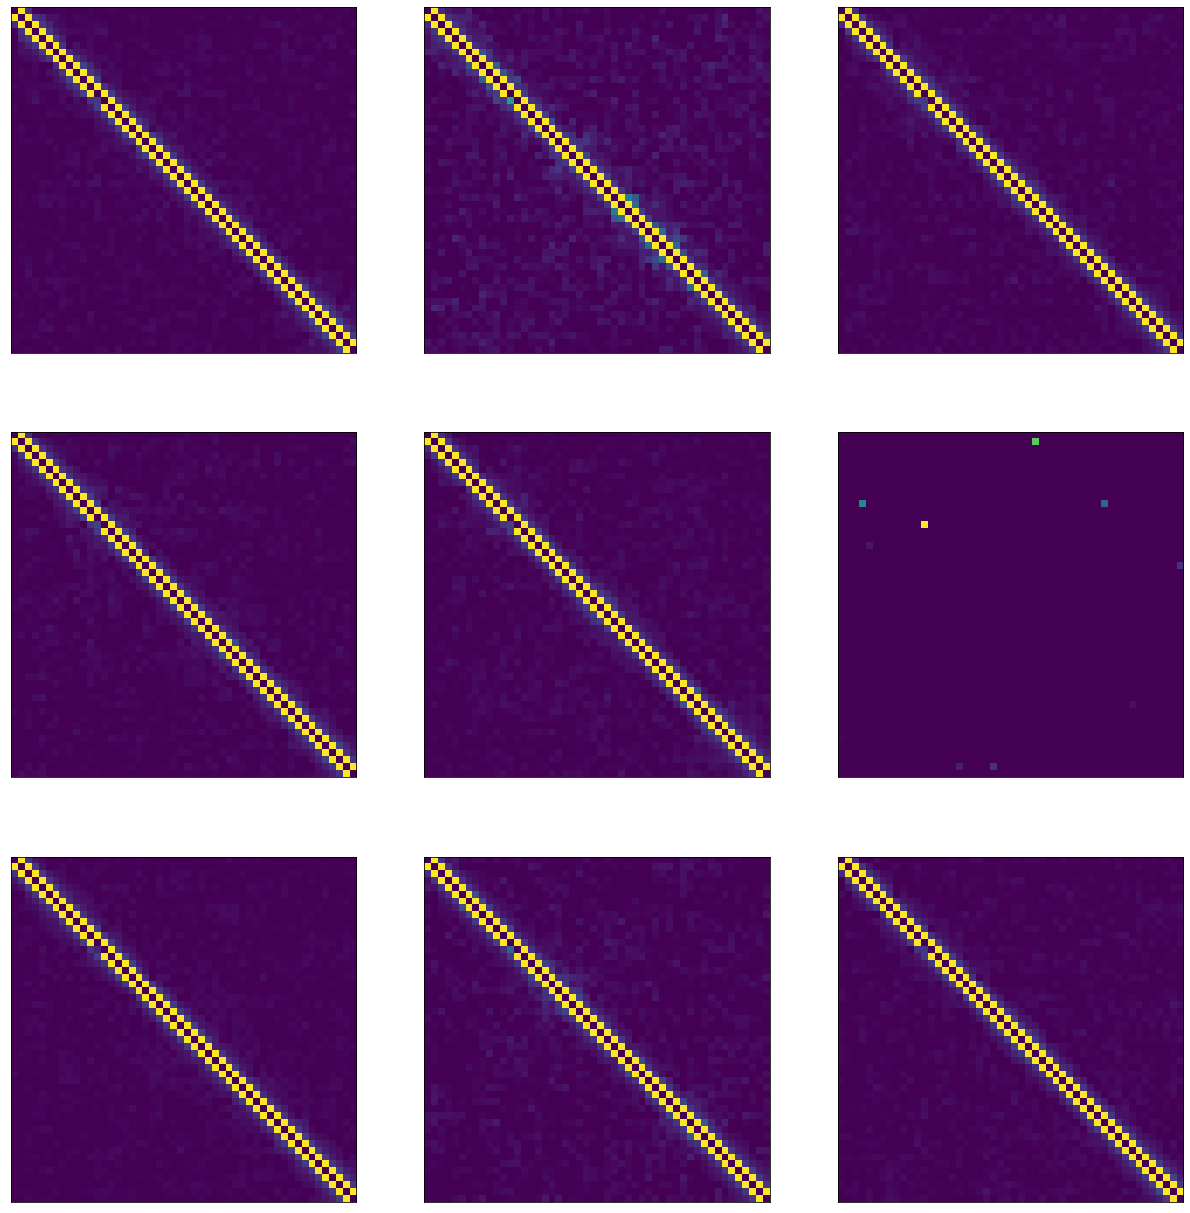

In [41]:
display_dictionary(W = W, figsize=[20,20])

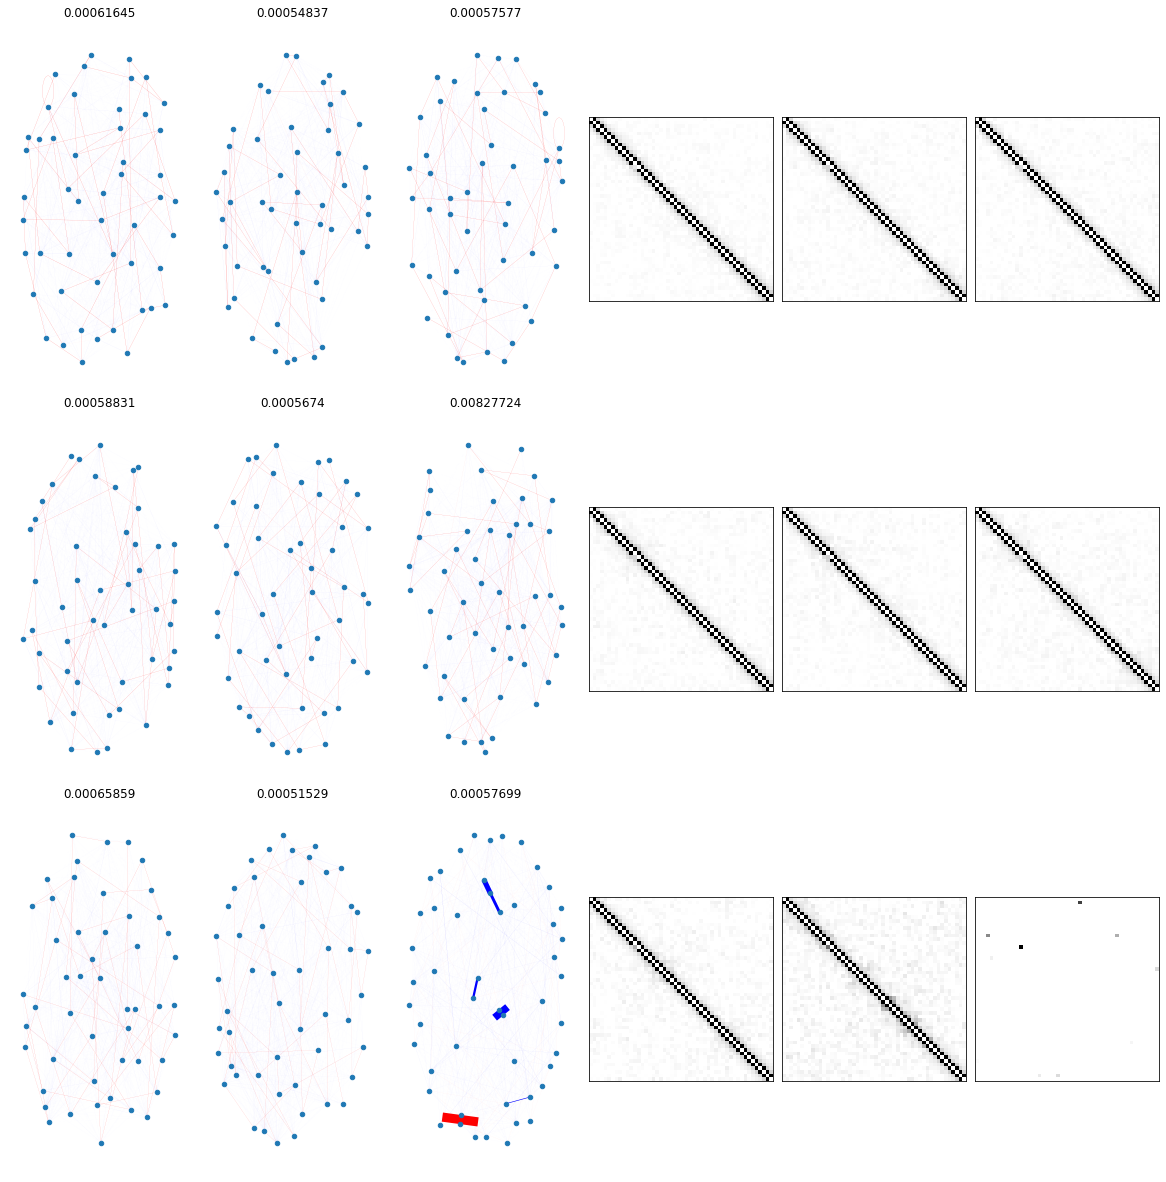

In [42]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 50, 
                       fig_size = [20,20], 
                       show_importance = False)